# Phase 4 Project

## Time Series Model

Let us start by loading the datasets and see what type of data we are dealing with

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

import scipy.stats as stats
from scipy.stats import kurtosis
from scipy.stats import skew

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.pylab import rcParams
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

Let's load US energy generation

In [2]:
df = pd.read_csv('organised_Gen.csv',
                 parse_dates={ 'date': ['YEAR', 'MONTH'] })
df

,date,Unnamed: 0,STATE,TYPE OF PRODUCER,ENERGY SOURCE,GENERATION (Megawatthours)
0,2001-01-01,0,AK,Total Electric Power Industry,Coal,46903.0
1,2001-01-01,1,AK,Total Electric Power Industry,Petroleum,71085.0
2,2001-01-01,2,AK,Total Electric Power Industry,Natural Gas,367521.0
3,2001-01-01,3,AK,Total Electric Power Industry,Hydroelectric Conventional,104549.0
4,2001-01-01,4,AK,Total Electric Power Industry,Wind,87.0
...,...,...,...,...,...,...
496769,2022-05-01,10581,WY,"Electric Generators, Electric Utilities",Coal,2071403.0
496770,2022-05-01,10582,WY,"Electric Generators, Electric Utilities",Hydroelectric Conventional,96790.0
496771,2022-05-01,10583,WY,"Electric Generators, Electric Utilities",Natural Gas,91570.0
496772,2022-05-01,10584,WY,"Electric Generators, Electric Utilities",Petroleum,1812.0


## Data Preparation:

In [3]:
df.set_index('date', inplace=True)
df.drop('Unnamed: 0', axis=1, inplace=True)
df

,STATE,TYPE OF PRODUCER,ENERGY SOURCE,GENERATION (Megawatthours)
date,,,,
2001-01-01,AK,Total Electric Power Industry,Coal,46903.0
2001-01-01,AK,Total Electric Power Industry,Petroleum,71085.0
2001-01-01,AK,Total Electric Power Industry,Natural Gas,367521.0
2001-01-01,AK,Total Electric Power Industry,Hydroelectric Conventional,104549.0
2001-01-01,AK,Total Electric Power Industry,Wind,87.0
...,...,...,...,...
2022-05-01,WY,"Electric Generators, Electric Utilities",Coal,2071403.0
2022-05-01,WY,"Electric Generators, Electric Utilities",Hydroelectric Conventional,96790.0
2022-05-01,WY,"Electric Generators, Electric Utilities",Natural Gas,91570.0


In [4]:
df.isna().sum()

STATE                         0
TYPE OF PRODUCER              0
ENERGY SOURCE                 0
GENERATION (Megawatthours)    0
dtype: int64

In [5]:
df.describe()

,GENERATION (Megawatthours)
count,4.967740e+05
mean,1.393384e+06
std,1.078685e+07
min,-9.978550e+05
25%,1.643000e+03
50%,2.330103e+04
75%,2.792042e+05
max,4.217967e+08


Very interesting! Could pick a couple of energy sources and analyze them in parallel

In [6]:
df['ENERGY SOURCE'].value_counts()

Total                             73356
Natural Gas                       66684
Petroleum                         63176
Coal                              47642
Other Biomass                     46148
Hydroelectric Conventional        38842
Other                             36241
Wood and Wood Derived Fuels       30524
Wind                              25421
Solar Thermal and Photovoltaic    19393
Other Gases                       18212
Nuclear                           16754
Pumped Storage                    10139
Geothermal                         4242
Name: ENERGY SOURCE, dtype: int64

In [7]:
df['TYPE OF PRODUCER'].value_counts()

Total Electric Power Industry                       134452
Electric Generators, Electric Utilities              93792
Electric Generators, Independent Power Producers     89439
Combined Heat and Power, Industrial Power            77804
Combined Heat and Power, Commercial Power            53928
Combined Heat and Power, Electric Power              47359
Name: TYPE OF PRODUCER, dtype: int64

In [8]:
US_total=df.loc[df['TYPE OF PRODUCER']=='Total Electric Power Industry']
US_total=US_total.loc[US_total['STATE']=='US-TOTAL']

In [9]:
US_total

,STATE,TYPE OF PRODUCER,ENERGY SOURCE,GENERATION (Megawatthours)
date,,,,
2001-01-01,US-TOTAL,Total Electric Power Industry,Coal,177287111.0
2001-01-01,US-TOTAL,Total Electric Power Industry,Petroleum,18111843.0
2001-01-01,US-TOTAL,Total Electric Power Industry,Natural Gas,42388663.0
2001-01-01,US-TOTAL,Total Electric Power Industry,Other Gases,718442.0
2001-01-01,US-TOTAL,Total Electric Power Industry,Nuclear,68707077.0
...,...,...,...,...
2022-05-01,US-TOTAL,Total Electric Power Industry,Petroleum,1524488.0
2022-05-01,US-TOTAL,Total Electric Power Industry,Solar Thermal and Photovoltaic,15151118.0
2022-05-01,US-TOTAL,Total Electric Power Industry,Other Biomass,1440366.0


In [10]:
US_total['ENERGY SOURCE'].value_counts()

Other Biomass                     257
Wind                              257
Solar Thermal and Photovoltaic    257
Petroleum                         257
Nuclear                           257
Geothermal                        257
Hydroelectric Conventional        257
Other Gases                       257
Wood and Wood Derived Fuels       257
Coal                              257
Total                             257
Pumped Storage                    257
Natural Gas                       257
Other                             257
Name: ENERGY SOURCE, dtype: int64

#### Changing Scale
GIven the high values for the column 'Generation (Megawatthours)' once we take the totals, we will convert the units to Terawatts per hour, where TWh=MWh*10^6.

In [11]:
US_total["Generation (TWh)"]=US_total["GENERATION (Megawatthours)"]/1000000
US_total.drop(['GENERATION (Megawatthours)'], axis=1, inplace=True)
US_total

,STATE,TYPE OF PRODUCER,ENERGY SOURCE,Generation (TWh)
date,,,,
2001-01-01,US-TOTAL,Total Electric Power Industry,Coal,177.287111
2001-01-01,US-TOTAL,Total Electric Power Industry,Petroleum,18.111843
2001-01-01,US-TOTAL,Total Electric Power Industry,Natural Gas,42.388663
2001-01-01,US-TOTAL,Total Electric Power Industry,Other Gases,0.718442
2001-01-01,US-TOTAL,Total Electric Power Industry,Nuclear,68.707077
...,...,...,...,...
2022-05-01,US-TOTAL,Total Electric Power Industry,Petroleum,1.524488
2022-05-01,US-TOTAL,Total Electric Power Industry,Solar Thermal and Photovoltaic,15.151118
2022-05-01,US-TOTAL,Total Electric Power Industry,Other Biomass,1.440366


In [12]:
US_source=US_total.groupby(by=[US_total.index,"ENERGY SOURCE"]).sum().reset_index()

In [13]:
US_source=US_source[(US_source['ENERGY SOURCE']!='Total')]

### Previewing the data by energy source

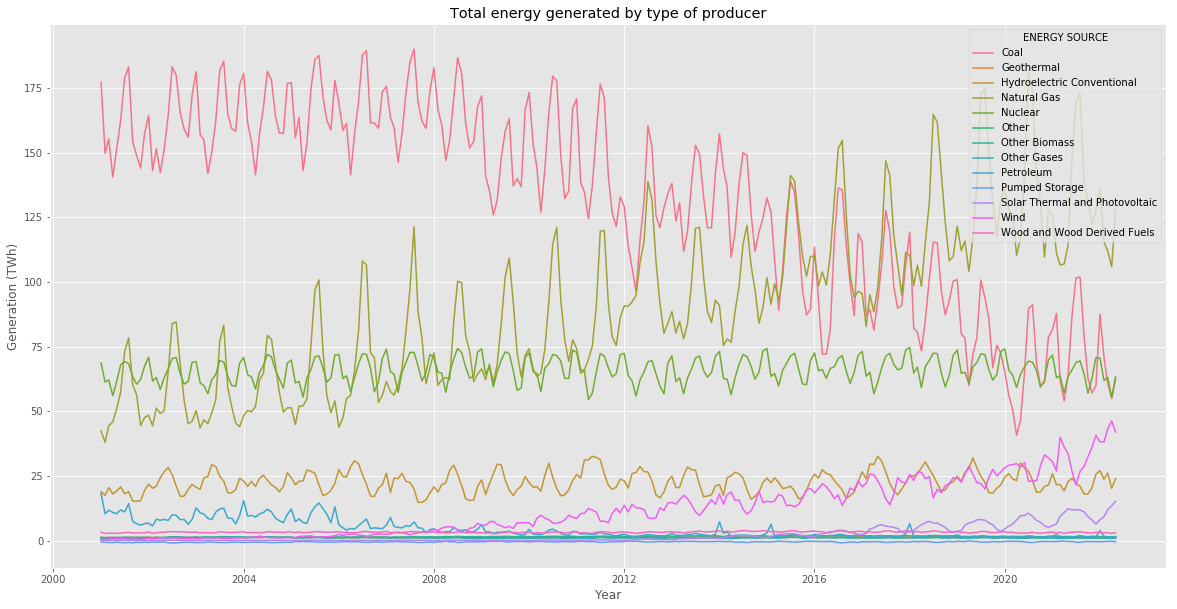

In [14]:
plt.figure(figsize=(20,10))
#Seaborn style
sns.color_palette("tab10")
#Plot - using mdates for correct datetime format
sns.lineplot(data=US_source, x=US_source['date'] ,y=US_source['Generation (TWh)'],hue="ENERGY SOURCE")
#Plot additional properties
#plt.grid()
#plt.xticks([str(i+2001)+"-01-01" for i in range(22)])
plt.title("Total energy generated by type of producer")
plt.xlabel("Year");
plt.show()


Let us divide up the energy sources to be able to better see form the graphs their trends.

In [15]:
top_3 = ['Coal' ,'Natural Gas', 'Nuclear'] 
US_top3=US_source[US_source['ENERGY SOURCE'].isin(top_3)]

In [16]:
US_top3

,date,ENERGY SOURCE,Generation (TWh)
0,2001-01-01,Coal,177.287111
3,2001-01-01,Natural Gas,42.388663
4,2001-01-01,Nuclear,68.707077
14,2001-02-01,Coal,149.735484
17,2001-02-01,Natural Gas,37.966927
...,...,...,...
3573,2022-04-01,Natural Gas,105.934050
3574,2022-04-01,Nuclear,55.289540
3584,2022-05-01,Coal,62.288238
3587,2022-05-01,Natural Gas,127.926186


### Top 3: Coal, Natural Gas and  Nuclear

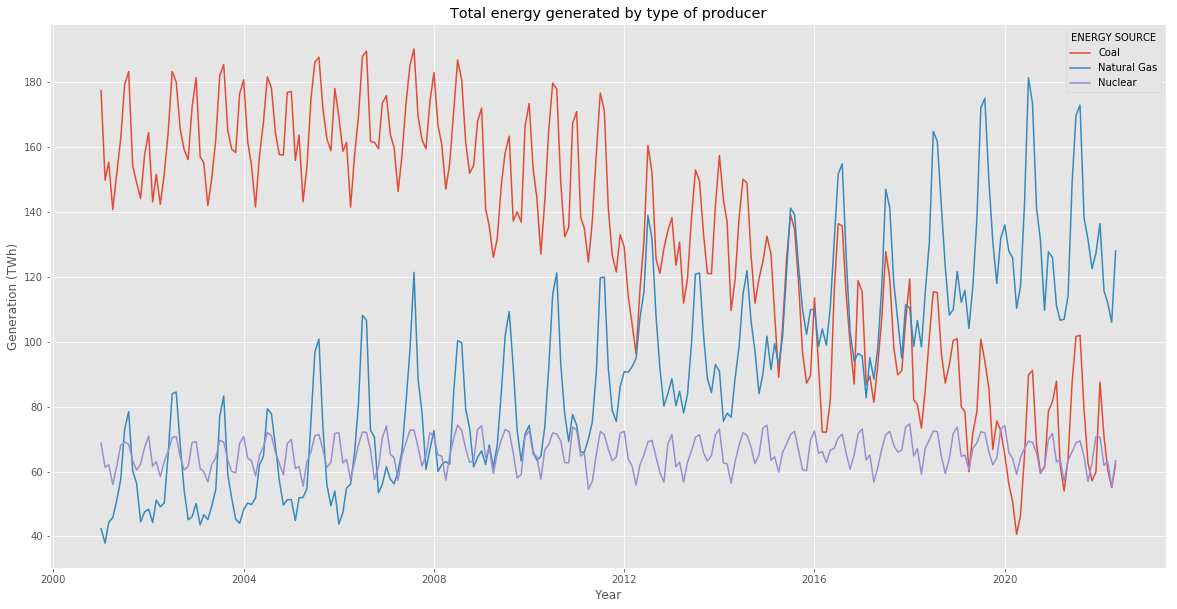

In [17]:
plt.figure(figsize=(20,10))
sns.color_palette("tab10")
sns.lineplot(data=US_top3, x=US_top3['date'] ,y=US_top3['Generation (TWh)'],hue="ENERGY SOURCE")
plt.title("Total energy generated by type of producer")
plt.xlabel("Year");
plt.show()


### Next 4: Wind, Hydroelectric, Solar and Oil

In [18]:
snd_4 = ['Wind' ,'Hydroelectric Conventional', 'Solar Thermal and Photovoltaic', 'Petroleum'] 
US_snd4=US_source[US_source['ENERGY SOURCE'].isin(snd_4)]

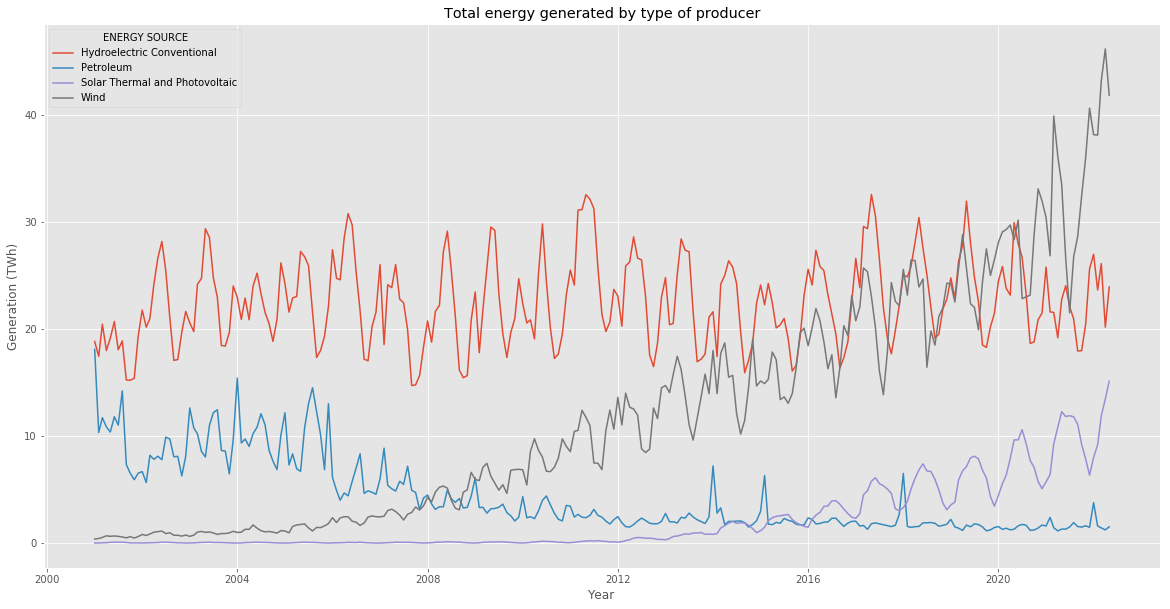

In [19]:
plt.figure(figsize=(20,10))
sns.color_palette("viridis")
sns.lineplot(data=US_snd4, x=US_snd4['date'] ,y=US_snd4['Generation (TWh)'],hue="ENERGY SOURCE")
plt.title("Total energy generated by type of producer")
plt.xlabel("Year");
plt.show()

### Bottom of the pack:

In [20]:
bottom=['Other','Other Gases','Pumped Storage','Wood and Wood Derived Fuels'\
        ,'Other Biomass','Geothermal']
US_bot=US_source[US_source['ENERGY SOURCE'].isin(bottom)]

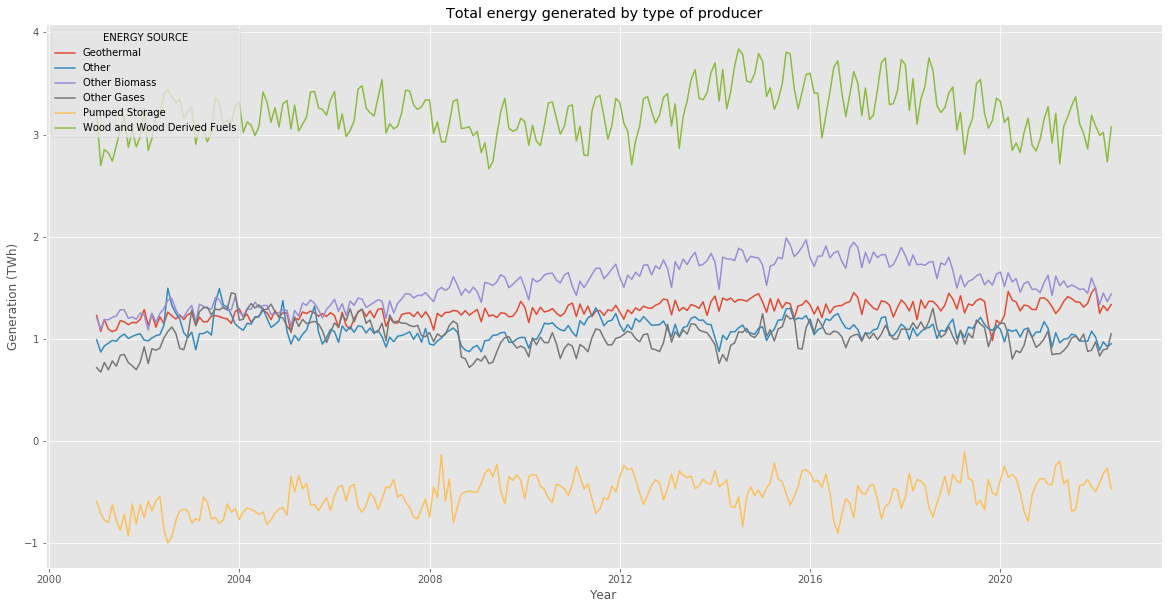

In [21]:
plt.figure(figsize=(20,10))
sns.color_palette("tab10")
sns.lineplot(data=US_bot, x=US_bot['date'] ,y=US_bot['Generation (TWh)'],hue="ENERGY SOURCE")
plt.title("Total energy generated by type of producer")
plt.xlabel("Year");
plt.show()

### The three most growing ones: Natural Gas, Solar and Wind

The trends that have shown to be more interesting, with an upward trend over time are:
 Natural Gas, Wind and Solar. So let us preview those.

> improve these graphs

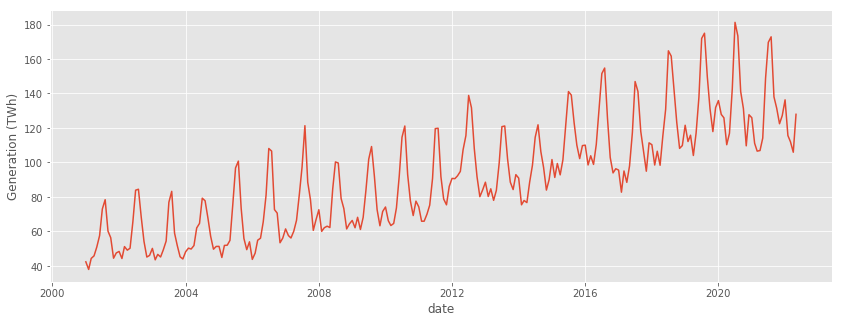

In [181]:
US_nat=US_total.loc[US_total['ENERGY SOURCE']=='Natural Gas']
sns.lineplot(x=US_nat.index, y=US_nat['Generation (TWh)']);

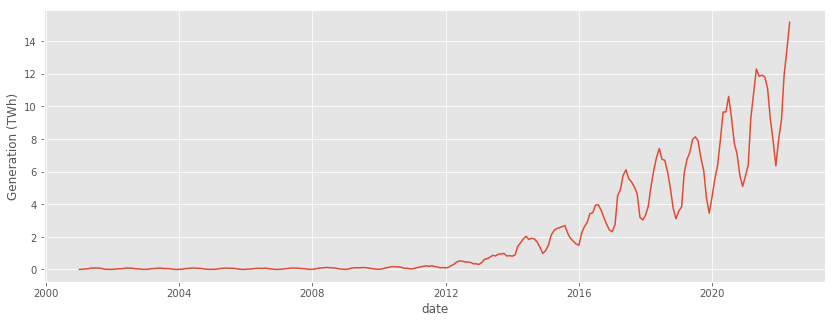

In [180]:
US_sol=US_total.loc[US_total['ENERGY SOURCE']=='Solar Thermal and Photovoltaic']
sns.lineplot(x=US_sol.index, y=US_sol['Generation (TWh)']);

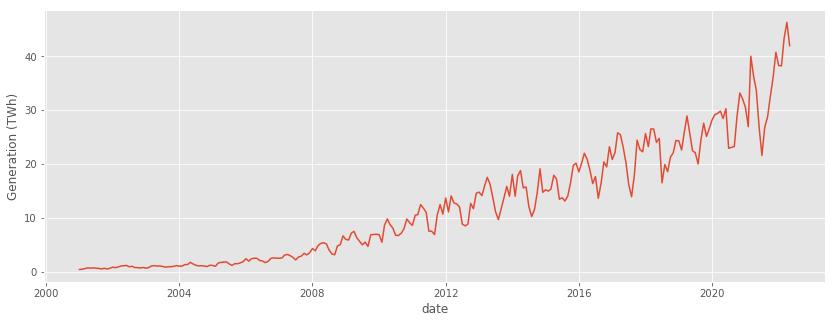

In [179]:
US_wind=US_total.loc[US_total['ENERGY SOURCE']=='Wind']
sns.lineplot(x=US_wind.index,y=US_wind['Generation (TWh)']);

## Checking for Normality, skewness and kurtosis

#### Natural Gas:

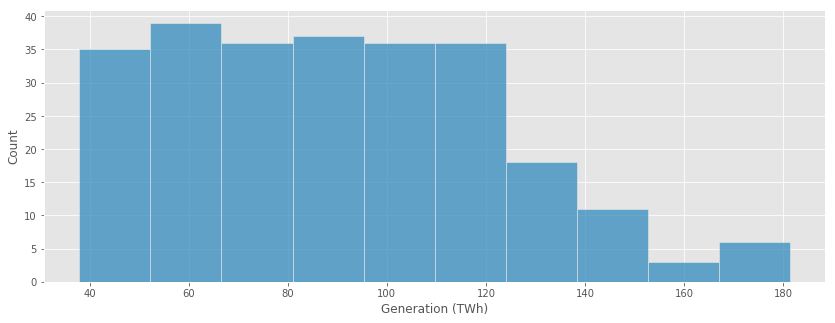

In [173]:
sns.histplot(US_nat['Generation (TWh)']);

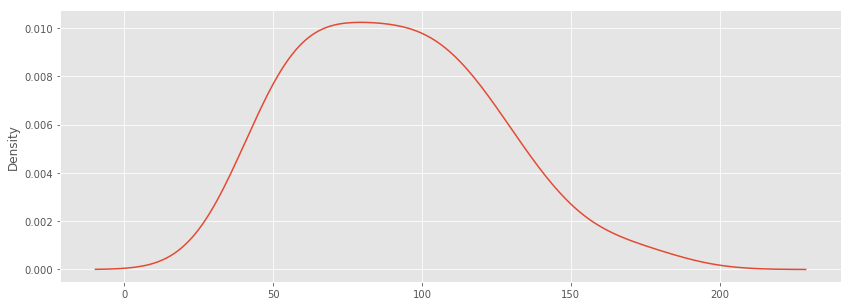

In [171]:
sns.kdeplot(np.array(US_nat['Generation (TWh)']), bw=0.5);

There is clearly a skew in the data because the lowest value of production we have, around 2001, is around 40 TWh, it does not start at zero. Let us use our tools from SciPy to get actual values for normality, skewness and kurtosis.

> Maybe here could add also histogram or density plot

## Split Train Validation and Test set

Now that we have decided what sources we are going to work on, we are going to perform a train-validation-test split so that the models we are going to create, based only on the information we have from the train, do not suffer from data-leaking.
We will consequently test our models on the validation set, to choose the best performing model, and we will utimately test it on the test set, that in this way will represent datat that was not unseen for the model.
We will use this comparison with the test to get a sense of our margins of error, and then use our model to forecast for the next 3 years.

In [25]:
nat=US_nat['Generation (TWh)']
sol=US_sol['Generation (TWh)']
wind=US_wind['Generation (TWh)']

In [26]:
# Definig the 80% cutoff for the split train - validation&test
cutoff = round(nat.shape[0]*0.8)
cutoff

206

In [27]:
# Defining the two sets, train and test& validation based on the cutoff
train = nat[:(cutoff+1)] #the +1 is added to avoid gaps in the series

testval = nat[cutoff:]


In [28]:
testval.index[0]

Timestamp('2018-03-01 00:00:00')

From here we can see that having performed an 80/20 split for train and test we have the year from January 2018 on as part of the test.
We want to create a validation set form the test set, that is usually around 20% but since the test is composed of 4 years to keep things more tidy, and be able to capture seasonality better in our validation set, we are going to make it 25%, so to be a whole year.

In [29]:
cutoff2 = round(testval.shape[0]*0.25)
cutoff2

13

In [30]:
val = testval[:(cutoff2+1)]

test = testval[cutoff2:]

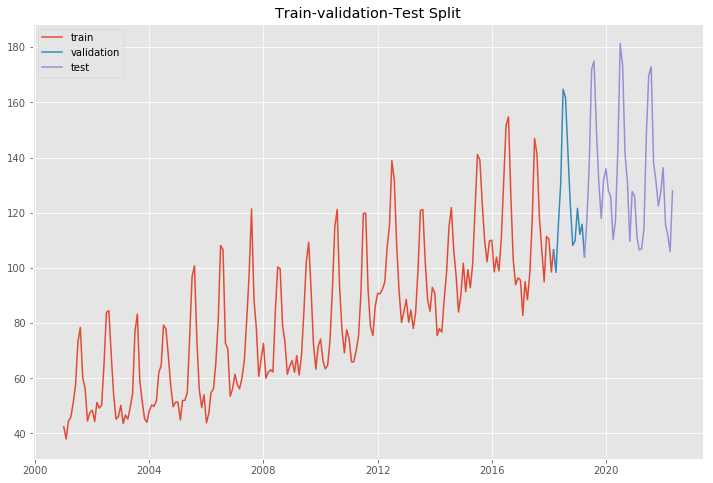

In [31]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(val, label='validation')
ax.plot(test, label='test')
ax.set_title('Train-validation-Test Split');
plt.legend();

In [32]:
test.index[0]

Timestamp('2019-04-01 00:00:00')

In [33]:
val.index[0]

Timestamp('2018-03-01 00:00:00')

In [34]:
train

date
2001-01-01     42.388663
2001-02-01     37.966927
2001-03-01     44.364414
2001-04-01     45.842746
2001-05-01     50.934205
                 ...    
2017-11-01     94.928341
2017-12-01    111.397792
2018-01-01    110.292909
2018-02-01     98.511852
2018-03-01    106.523780
Name: Generation (TWh), Length: 207, dtype: float64

In [35]:
val

date
2018-03-01    106.523780
2018-04-01     98.371080
2018-05-01    115.283982
2018-06-01    130.826400
2018-07-01    164.749060
2018-08-01    161.676241
2018-09-01    141.785528
2018-10-01    123.142239
2018-11-01    108.167635
2018-12-01    109.801976
2019-01-01    121.581777
2019-02-01    112.135473
2019-03-01    115.806072
2019-04-01    104.053161
Name: Generation (TWh), dtype: float64

In [36]:
test

date
2019-04-01    104.053161
2019-05-01    117.052615
2019-06-01    137.827808
2019-07-01    171.941961
2019-08-01    174.955372
2019-09-01    149.687661
2019-10-01    130.940660
2019-11-01    117.903947
2019-12-01    131.830286
2020-01-01    135.905175
2020-02-01    127.861217
2020-03-01    125.895408
2020-04-01    110.291535
2020-05-01    116.933505
2020-06-01    142.822497
2020-07-01    181.248097
2020-08-01    173.379404
2020-09-01    141.155144
2020-10-01    131.232950
2020-11-01    109.650802
2020-12-01    127.674265
2021-01-01    125.959747
2021-02-01    111.110664
2021-03-01    106.565144
2021-04-01    106.920249
2021-05-01    114.131496
2021-06-01    148.842629
2021-07-01    169.662613
2021-08-01    172.859149
2021-09-01    138.061580
2021-10-01    131.489744
2021-11-01    122.458121
2021-12-01    127.168673
2022-01-01    136.317103
2022-02-01    115.615259
2022-03-01    112.002542
2022-04-01    105.934050
2022-05-01    127.926186
Name: Generation (TWh), dtype: float64

In [37]:
"""split = TimeSeriesSplit()

for train_ind, val_ind in split.split(train):
    print(train_ind, val_ind)"""

'split = TimeSeriesSplit()\n\nfor train_ind, val_ind in split.split(train):\n    print(train_ind, val_ind)'

### Subtracting Rolling Mean

In [38]:
roll_mean = train.rolling(window=12, center=False).mean()
roll_std = train.rolling(window=12, center=False).std()

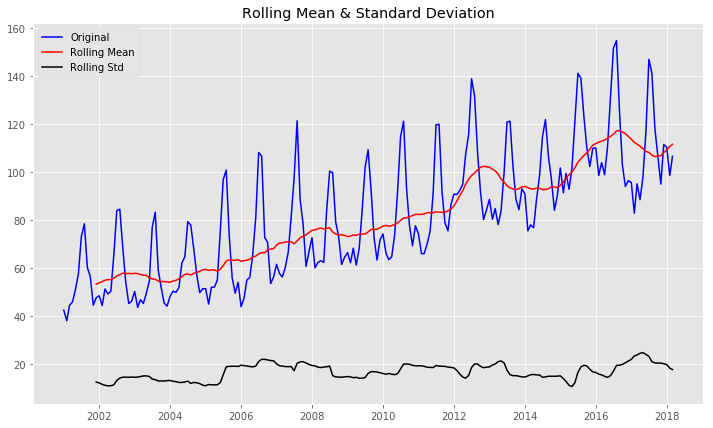

In [39]:
fig = plt.figure(figsize=(12,7))
plt.plot(train, color='blue', label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [40]:
dftest = adfuller(train)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dftest)

(-0.4857072897184561, 0.8947755741324734, 15, 191, {'1%': -3.465058702600837, '5%': -2.8767942675230356, '10%': -2.5749014492475535}, 1250.5326958945707)


In [41]:
print ('Results of Dickey-Fuller test: \n')

print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -0.485707
p-value                          0.894776
#Lags Used                      15.000000
Number of Observations Used    191.000000
Critical Value (1%)             -3.465059
Critical Value (5%)             -2.876794
Critical Value (10%)            -2.574901
dtype: float64


The p values is clearly > 0.05, the series is not stationary as we could expect.

In [42]:

#coal=US_coal['Generation (TWh)']
#oil=US_oil['Generation (TWh)']

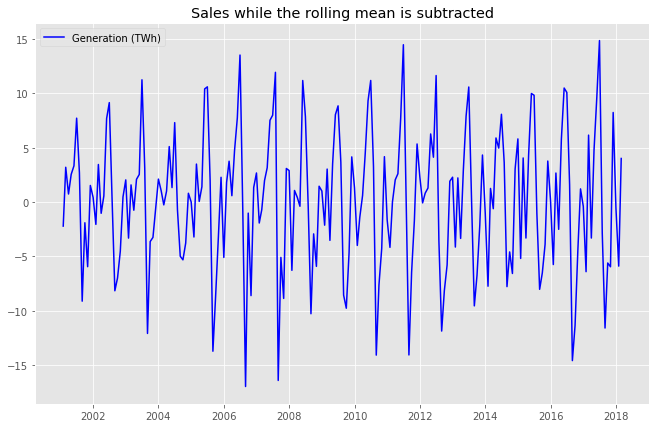

In [43]:
roll_mean_nat = train.rolling(window=2, center=False).mean()
# Subtract the moving average from the original data
data_mrm_nat = train - roll_mean_nat
# Drop the missing values from time series calculated above
data_mrm_nat.dropna(inplace=True)
# Plot sales with rolling mean subtracted
fig = plt.figure(figsize=(11,7))
plt.plot(data_mrm_nat, color='blue')#,label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Sales while the rolling mean is subtracted')
plt.show();#(block=False)

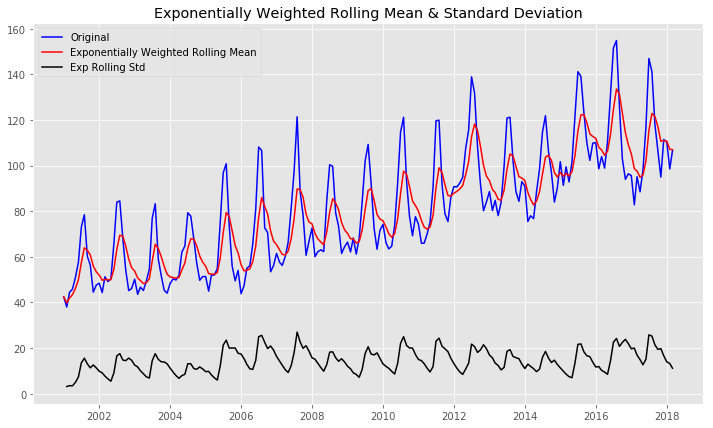

In [44]:
# Use Pandas ewm() to calculate Exponential Weighted Moving Average
exp_roll_mean = train.ewm(halflife=2).mean()
roll_std = train.ewm(halflife=2).std()
# Plot the original data with exp weighted average
fig = plt.figure(figsize=(12,7))
orig = plt.plot(train, color='blue',label='Original')
mean = plt.plot(exp_roll_mean, color='red', label='Exponentially Weighted Rolling Mean')
plt.plot(roll_std, color='black', label = 'Exp Rolling Std')
plt.legend(loc='best')
plt.title('Exponentially Weighted Rolling Mean & Standard Deviation')
plt.show(block=False)

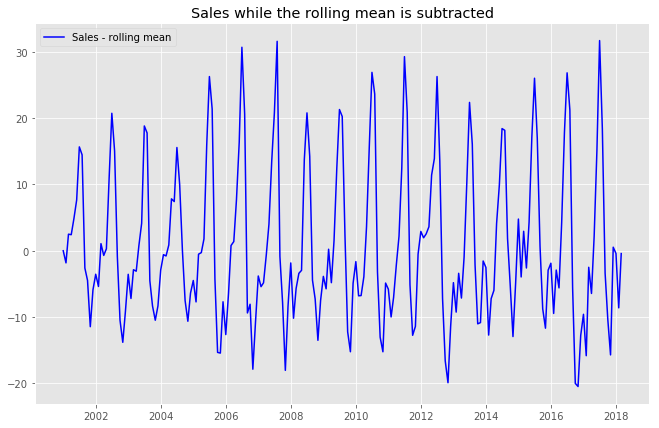

In [45]:
# Subtract the moving average from the original data
data_minus_exp_roll_mean = train - exp_roll_mean
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_exp_roll_mean, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Sales while the rolling mean is subtracted')
plt.show(block=False)

In [46]:
dftest = adfuller(data_mrm_nat)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -4.202030
p-value                          0.000654
#Lags Used                      15.000000
Number of Observations Used    190.000000
Critical Value (1%)             -3.465244
Critical Value (5%)             -2.876875
Critical Value (10%)            -2.574945
dtype: float64


In [47]:
dftest = adfuller(data_minus_exp_roll_mean)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -4.697668
p-value                          0.000085
#Lags Used                      14.000000
Number of Observations Used    192.000000
Critical Value (1%)             -3.464875
Critical Value (5%)             -2.876714
Critical Value (10%)            -2.574859
dtype: float64


> Here maybe a paragraph in which you explain what it means, the fact that the residualas are stationary and why do we subract the rolling mean, because there is a dependence on the previous periods, specifically the amounts of periods specified in the window. And that expotential means the ones closer in time are more relevant then the others.

## Series Decomposition

**When log is better than natural, is because the trend is exponential (growth in our case) inste of linear growth.**

### Decomposing Natural Gas

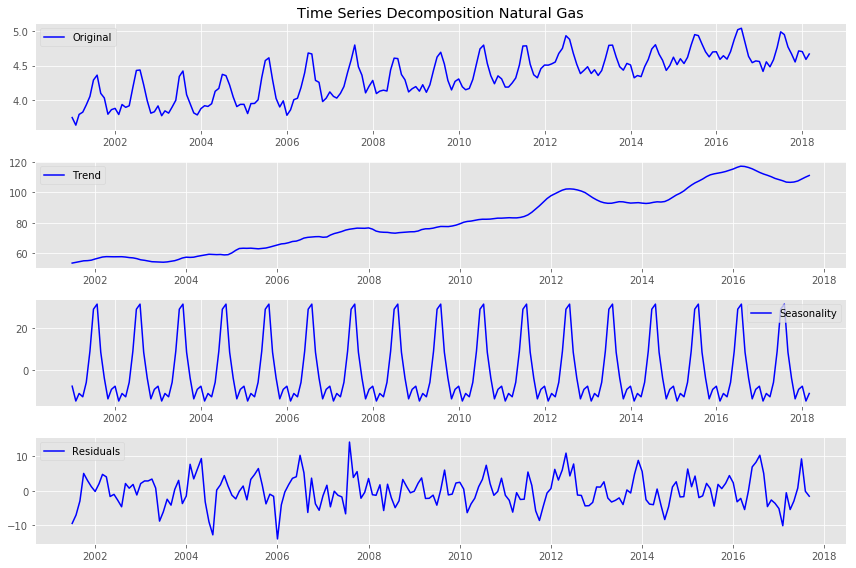

In [48]:
decomposition = seasonal_decompose(train)

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.title('Time Series Decomposition Natural Gas')
plt.plot(np.log(train), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')

plt.tight_layout();

In [49]:
residual.dropna(inplace=True)

In [50]:
dftest = adfuller(residual)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                -6.072536e+00
p-value                        1.141737e-07
#Lags Used                     1.500000e+01
Number of Observations Used    1.790000e+02
Critical Value (1%)           -3.467420e+00
Critical Value (5%)           -2.877826e+00
Critical Value (10%)          -2.575452e+00
dtype: float64


### Decomposing log(natural gas)

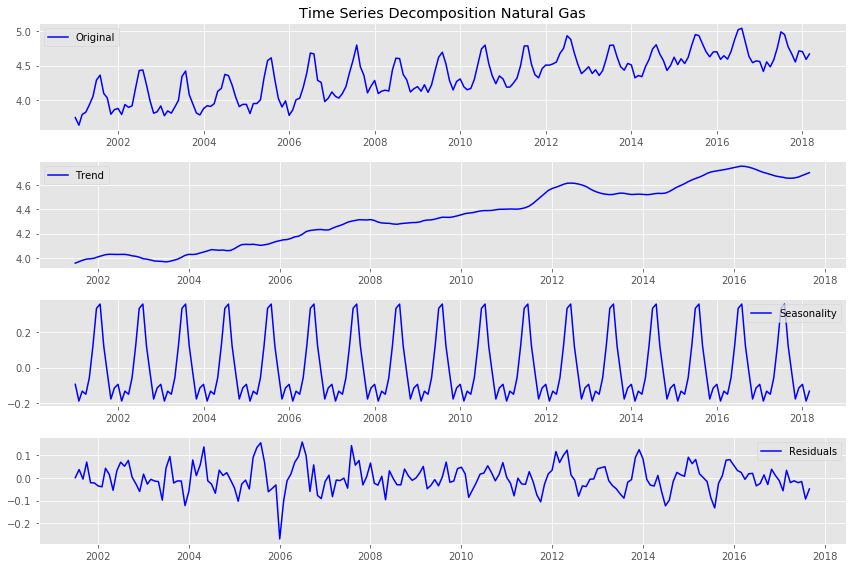

In [51]:
decomposition = seasonal_decompose(np.log(train))

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.title('Time Series Decomposition Natural Gas')
plt.plot(np.log(train), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')

plt.tight_layout();

In [52]:
residual.dropna(inplace=True)
dftest = adfuller(residual)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                -8.280252e+00
p-value                        4.540005e-13
#Lags Used                     8.000000e+00
Number of Observations Used    1.860000e+02
Critical Value (1%)           -3.466005e+00
Critical Value (5%)           -2.877208e+00
Critical Value (10%)          -2.575122e+00
dtype: float64


## Multiplicative instead of additive models

Not getting better. Let's try multiplicative instead of additive. Back to the whole series, which performed better.

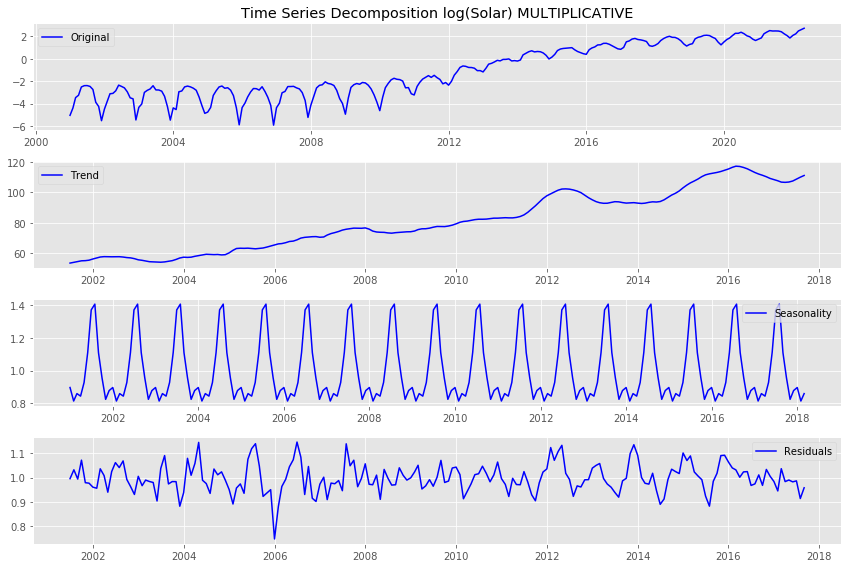

In [53]:
decomposition = seasonal_decompose(train, model='multiplicative')

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.title('Time Series Decomposition log(Solar) MULTIPLICATIVE')
plt.plot(np.log(sol), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

In [54]:
residual.dropna(inplace=True)
dftest = adfuller(residual)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -5.519263
p-value                          0.000002
#Lags Used                       9.000000
Number of Observations Used    185.000000
Critical Value (1%)             -3.466201
Critical Value (5%)             -2.877293
Critical Value (10%)            -2.575168
dtype: float64


Much better!
Now out of curiosity let me try to do multiplicative for the other resources too and see if the residulas improve.

### Multiplicative log

Results of Dickey-Fuller test: 

Test Statistic                -8.808333e+00
p-value                        2.023057e-14
#Lags Used                     8.000000e+00
Number of Observations Used    1.860000e+02
Critical Value (1%)           -3.466005e+00
Critical Value (5%)           -2.877208e+00
Critical Value (10%)          -2.575122e+00
dtype: float64


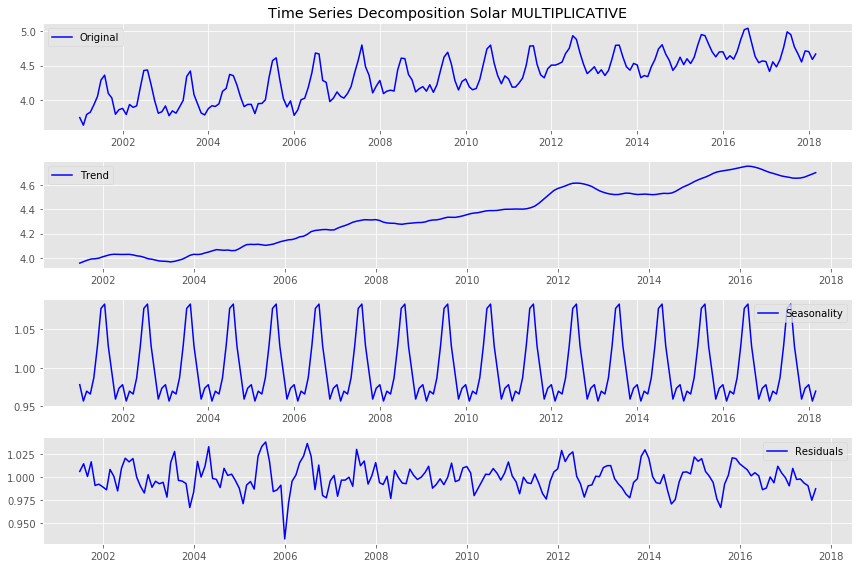

In [55]:
decomposition = seasonal_decompose(np.log(train), model='multiplicative')

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.title('Time Series Decomposition Solar MULTIPLICATIVE')
plt.plot(np.log(train), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()
residual.dropna(inplace=True)
dftest = adfuller(residual)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

## Studying Autocorrelation

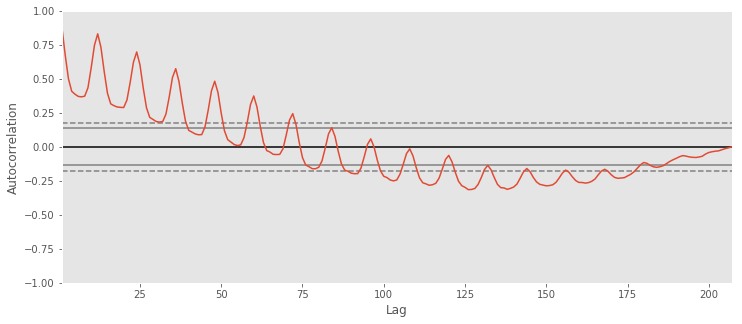

In [56]:
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(train);

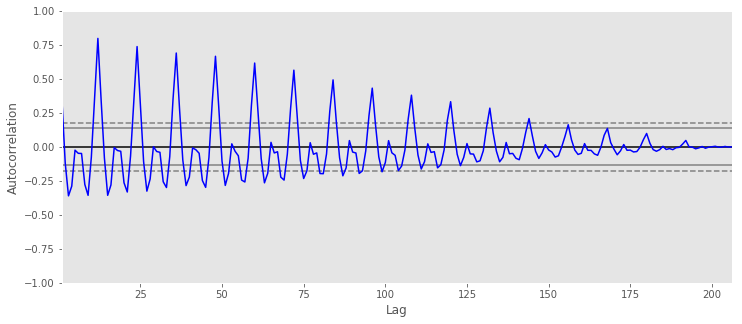

In [57]:
nat_diff = train.diff(periods=1)
nat_diff.dropna(inplace=True)
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(nat_diff, color='b');

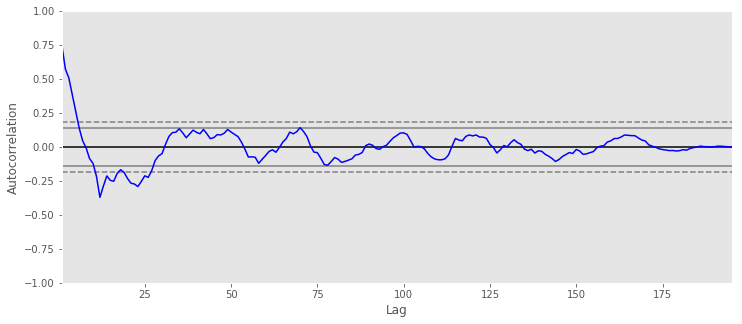

In [58]:
nat_diff12 = train.diff(periods=12)
nat_diff12.dropna(inplace=True)
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(nat_diff12, color='b');

## PACF

### Natural Gas

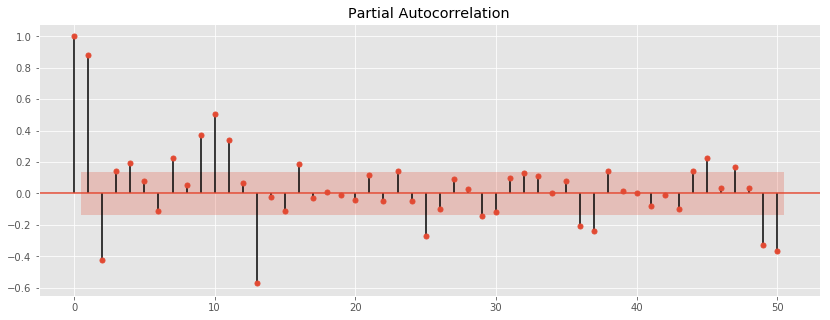

In [59]:
rcParams['figure.figsize'] = 14, 5

plot_pacf(train, lags=50);

## ACF

### Natural Gas

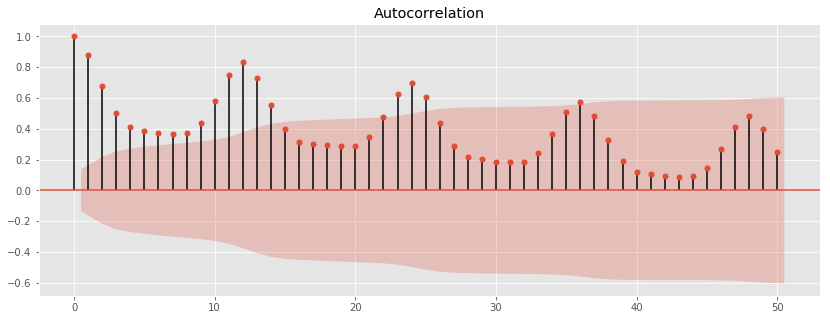

In [60]:
rcParams['figure.figsize'] = 14, 5

plot_acf(train, lags=50);

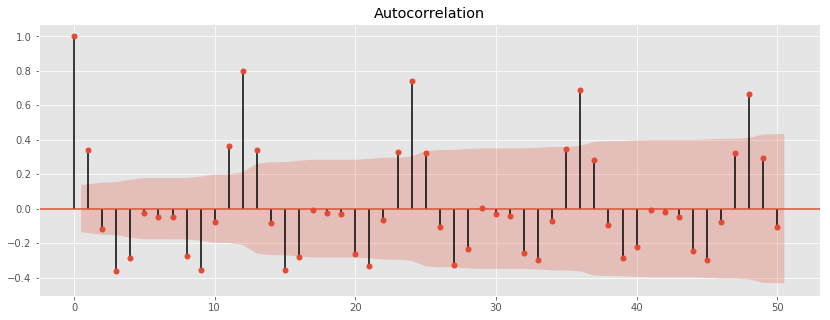

In [61]:
rcParams['figure.figsize'] = 14, 5

plot_acf(nat_diff, lags=50);

### PACF with first difference

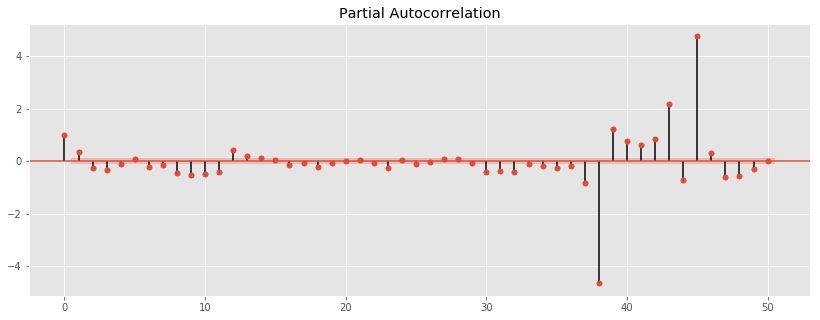

In [62]:
nat_diff = nat.diff(periods=1)
nat_diff.dropna(inplace=True)
rcParams['figure.figsize'] = 14, 5

plot_pacf(nat_diff, lags=50);

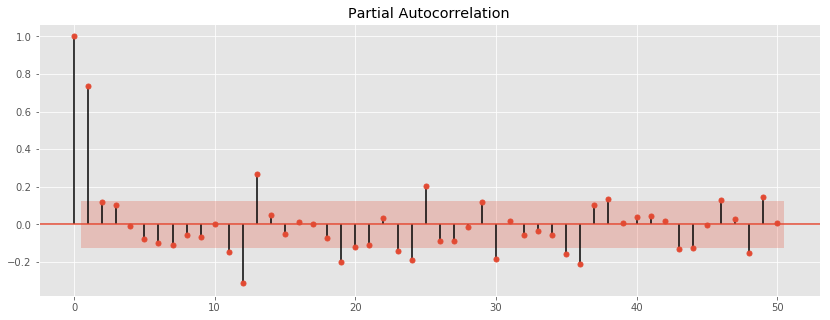

In [63]:
nat_diff = nat.diff(periods=12)
nat_diff.dropna(inplace=True)
rcParams['figure.figsize'] = 14, 5

plot_pacf(nat_diff, lags=50);

> look into this, why with periods = 12 the pacf makes much mores sense

> also: why does the PACF make more sense with the differenced 1 time series? Try to understand this.

> another idea create a DF with one column per source and then see if there is correlation between them
> the correlation can be seen with df.corr( ) and I can also do it on the series that are differenced

From here on we will dig deeper into natural gas as it is higher in production and is a more stable source of energy since it does not depend on uncontrollable factors like weather, which is the case for solar and wind.
We might go back to solar and wind after finished with Natural if there is time.

# Modeling

## Baseline Model:

> Make Naive Bayes and calculate RMSE as the base to keep

## ARMA models

### AR model

In [64]:
mod_arma = ARIMA(train, order=(1,0,0))

In [65]:
# Fit the model to data
res_arma = mod_arma.fit()

In [66]:
# Print out summary information on the fit
print(res_arma.summary())

                               SARIMAX Results                                
Dep. Variable:       Generation (TWh)   No. Observations:                  207
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -808.522
Date:                Sun, 12 Mar 2023   AIC                           1623.044
Time:                        22:14:04   BIC                           1633.042
Sample:                    01-01-2001   HQIC                          1627.087
                         - 03-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         80.5313      7.535     10.687      0.000      65.762      95.300
ar.L1          0.8870      0.033     26.675      0.000       0.822       0.952
sigma2       143.5185     14.440      9.939      0.0

In [67]:
# Print out the estimate for the constant and for theta
print(res_arma.params)

const      80.531265
ar.L1       0.886972
sigma2    143.518486
dtype: float64


### AR with First Difference

In [68]:
mod_arma = ARIMA(train, order=(1,1,0))

In [69]:
# Fit the model to data
res_arma = mod_arma.fit()

In [70]:
# Print out summary information on the fit
print(res_arma.summary())

                               SARIMAX Results                                
Dep. Variable:       Generation (TWh)   No. Observations:                  207
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -796.759
Date:                Sun, 12 Mar 2023   AIC                           1597.518
Time:                        22:14:04   BIC                           1604.174
Sample:                    01-01-2001   HQIC                          1600.210
                         - 03-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3430      0.068      5.039      0.000       0.210       0.476
sigma2       133.8912     12.171     11.000      0.000     110.036     157.747
Ljung-Box (L1) (Q):                   1.82   Jarque-

### ARMA with first difference

In [71]:
mod_arma = ARIMA(train, order=(1,1,1))

In [72]:
# Fit the model to data
res_arma = mod_arma.fit()

In [73]:
# Print out summary information on the fit
print(res_arma.summary())

                               SARIMAX Results                                
Dep. Variable:       Generation (TWh)   No. Observations:                  207
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -793.475
Date:                Sun, 12 Mar 2023   AIC                           1592.950
Time:                        22:14:04   BIC                           1602.933
Sample:                    01-01-2001   HQIC                          1596.987
                         - 03-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0746      0.164      0.455      0.649      -0.247       0.396
ma.L1          0.3375      0.147      2.300      0.021       0.050       0.625
sigma2       129.6560     12.546     10.334      0.0

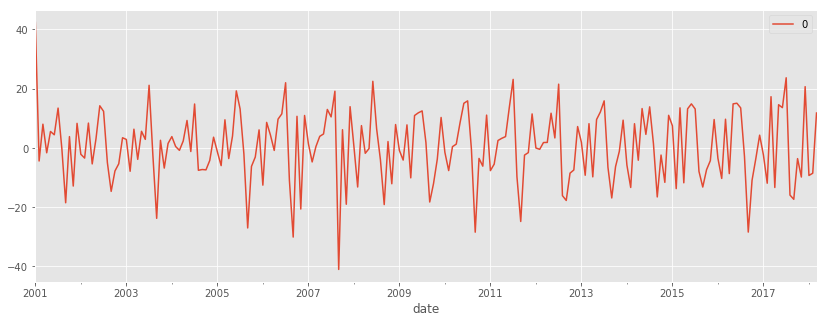

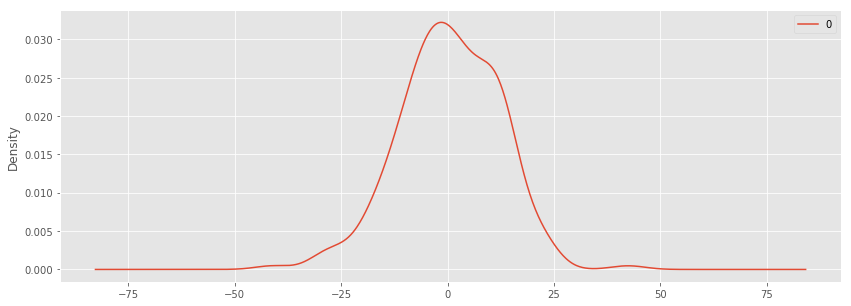

                0
count  207.000000
mean     0.435011
std     11.756272
min    -41.044733
25%     -7.338286
50%      0.465362
75%      9.421939
max     42.388663


In [74]:
# line plot of residuals
residuals = pd.DataFrame(res_arma.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [75]:
residuals.dropna(inplace=True)
dftest = adfuller(residuals)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -4.075838
p-value                          0.001062
#Lags Used                      15.000000
Number of Observations Used    191.000000
Critical Value (1%)             -3.465059
Critical Value (5%)             -2.876794
Critical Value (10%)            -2.574901
dtype: float64


### Trying higher orders

#### 211

In [76]:
mod_arma = ARIMA(train, order=(2,1,1))

In [77]:
# Fit the model to data
res_arma = mod_arma.fit()

In [78]:
# Print out summary information on the fit
print(res_arma.summary())

                               SARIMAX Results                                
Dep. Variable:       Generation (TWh)   No. Observations:                  207
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -765.855
Date:                Sun, 12 Mar 2023   AIC                           1539.711
Time:                        22:14:05   BIC                           1553.022
Sample:                    01-01-2001   HQIC                          1545.094
                         - 03-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1311      0.065     17.443      0.000       1.004       1.258
ar.L2         -0.5445      0.059     -9.232      0.000      -0.660      -0.429
ma.L1         -0.9233      0.037    -24.912      0.0

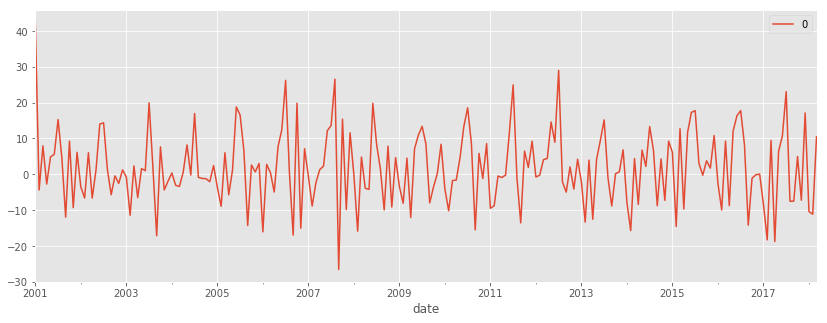

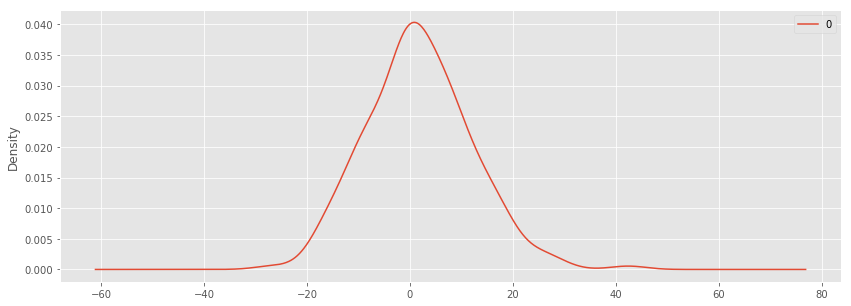

                0
count  207.000000
mean     1.777620
std     10.215742
min    -26.598634
25%     -4.410160
50%      1.166748
75%      8.186121
max     42.388663


In [79]:
# line plot of residuals
residuals = pd.DataFrame(res_arma.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [80]:
residuals.dropna(inplace=True)
dftest = adfuller(residuals)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -4.010956
p-value                          0.001354
#Lags Used                      15.000000
Number of Observations Used    191.000000
Critical Value (1%)             -3.465059
Critical Value (5%)             -2.876794
Critical Value (10%)            -2.574901
dtype: float64


#### 212

In [81]:
mod_arma = ARIMA(train, order=(2,1,2))

In [82]:
res_arma = mod_arma.fit()

In [83]:
print(res_arma.summary())

                               SARIMAX Results                                
Dep. Variable:       Generation (TWh)   No. Observations:                  207
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -765.403
Date:                Sun, 12 Mar 2023   AIC                           1540.805
Time:                        22:14:06   BIC                           1557.445
Sample:                    01-01-2001   HQIC                          1547.535
                         - 03-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2238      0.126      9.706      0.000       0.977       1.471
ar.L2         -0.6165      0.105     -5.865      0.000      -0.822      -0.410
ma.L1         -1.0557      0.158     -6.662      0.0

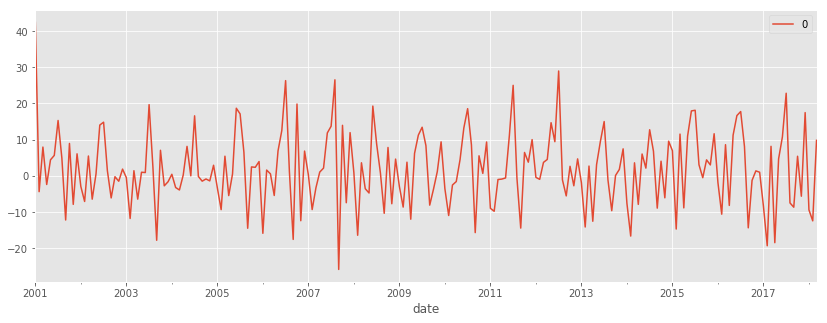

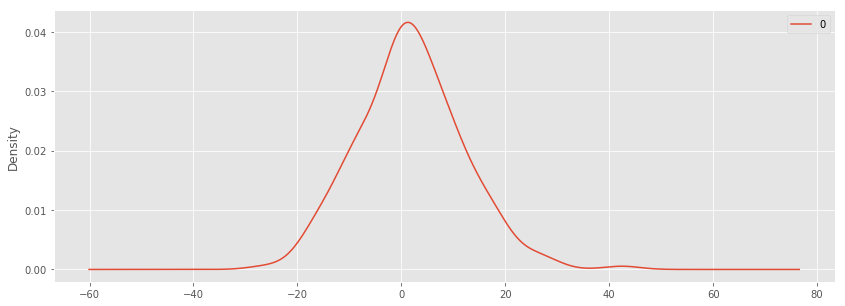

                0
count  207.000000
mean     1.793617
std     10.190165
min    -25.927325
25%     -4.607756
50%      1.143238
75%      8.073709
max     42.388663


In [84]:
# line plot of residuals
residuals = pd.DataFrame(res_arma.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [85]:
residuals.dropna(inplace=True)
dftest = adfuller(residuals)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -4.078831
p-value                          0.001050
#Lags Used                      15.000000
Number of Observations Used    191.000000
Critical Value (1%)             -3.465059
Critical Value (5%)             -2.876794
Critical Value (10%)            -2.574901
dtype: float64


#### 214

In [86]:
mod_arma = ARIMA(train, order=(2,1,4))

In [87]:
res_arma = mod_arma.fit()

In [88]:
print(res_arma.summary())

                               SARIMAX Results                                
Dep. Variable:       Generation (TWh)   No. Observations:                  207
Model:                 ARIMA(2, 1, 4)   Log Likelihood                -763.744
Date:                Sun, 12 Mar 2023   AIC                           1541.489
Time:                        22:14:08   BIC                           1564.784
Sample:                    01-01-2001   HQIC                          1550.910
                         - 03-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0615      0.267     -0.230      0.818      -0.585       0.462
ar.L2         -0.0879      0.183     -0.480      0.631      -0.447       0.271
ma.L1          0.2887      0.251      1.151      0.2

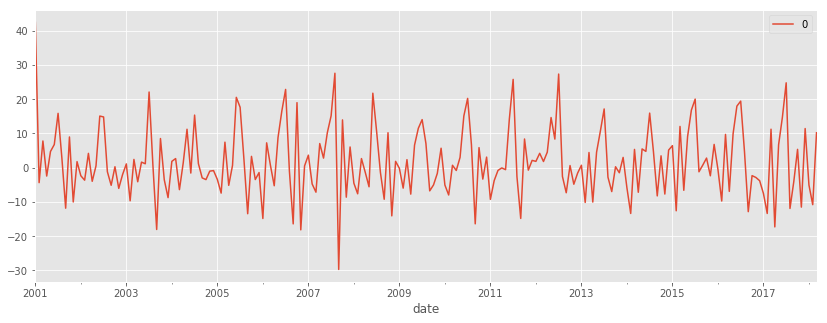

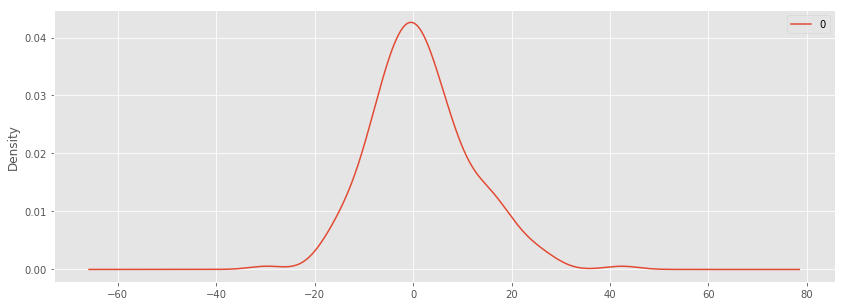

                0
count  207.000000
mean     1.672333
std     10.136257
min    -29.768299
25%     -4.987405
50%      0.656993
75%      7.000448
max     42.388663


In [89]:
# line plot of residuals
residuals = pd.DataFrame(res_arma.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [90]:
residuals.dropna(inplace=True)
dftest = adfuller(residuals)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -3.903255
p-value                          0.002011
#Lags Used                      15.000000
Number of Observations Used    191.000000
Critical Value (1%)             -3.465059
Critical Value (5%)             -2.876794
Critical Value (10%)            -2.574901
dtype: float64


#### 015

In [91]:
mod_arma = ARIMA(train, order=(0,1,5))

In [92]:
res_arma = mod_arma.fit()

In [93]:
print(res_arma.summary())

                               SARIMAX Results                                
Dep. Variable:       Generation (TWh)   No. Observations:                  207
Model:                 ARIMA(0, 1, 5)   Log Likelihood                -763.889
Date:                Sun, 12 Mar 2023   AIC                           1539.779
Time:                        22:14:09   BIC                           1559.746
Sample:                    01-01-2001   HQIC                          1547.854
                         - 03-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2244      0.061      3.677      0.000       0.105       0.344
ma.L2         -0.2100      0.066     -3.173      0.002      -0.340      -0.080
ma.L3         -0.4808      0.065     -7.426      0.0

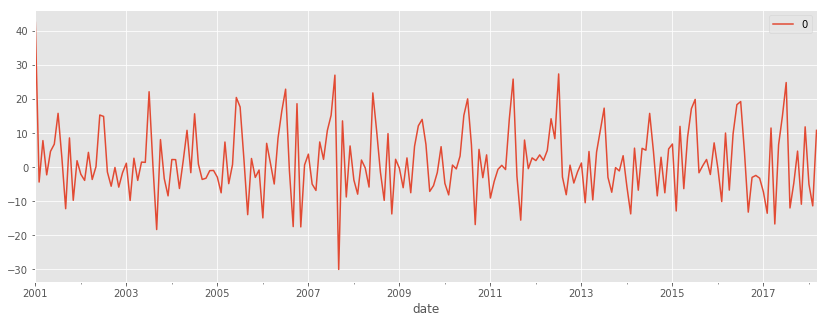

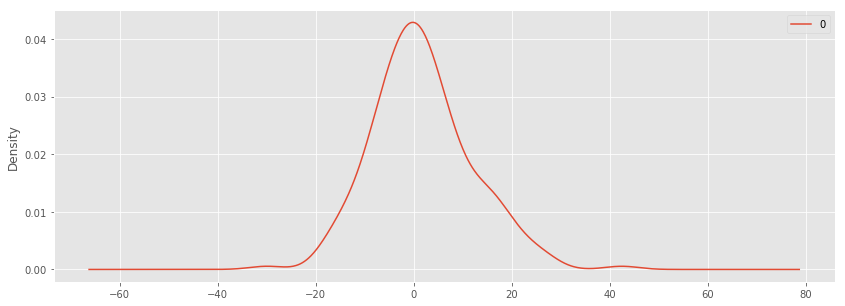

                0
count  207.000000
mean     1.664827
std     10.144959
min    -30.038431
25%     -4.851859
50%      0.638377
75%      6.997186
max     42.388663


In [94]:
# line plot of residuals
residuals = pd.DataFrame(res_arma.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())



In [95]:
residuals.dropna(inplace=True)
dftest = adfuller(residuals)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -3.798635
p-value                          0.002921
#Lags Used                      15.000000
Number of Observations Used    191.000000
Critical Value (1%)             -3.465059
Critical Value (5%)             -2.876794
Critical Value (10%)            -2.574901
dtype: float64


## Grid search for ARIMA model

Defining a few functions to do a grid search on the ARIMA model.

In [96]:
"""# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
     # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error
"""

'# evaluate an ARIMA model for a given order (p,d,q)\ndef evaluate_arima_model(X, arima_order):\n    # prepare training dataset\n    train_size = int(len(X) * 0.66)\n    train, test = X[0:train_size], X[train_size:]\n    history = [x for x in train]\n    # make predictions\n    predictions = list()\n    for t in range(len(test)):\n        model = ARIMA(history, order=arima_order)\n        model_fit = model.fit()\n        yhat = model_fit.forecast()[0]\n        predictions.append(yhat)\n        history.append(test[t])\n     # calculate out of sample error\n    error = mean_squared_error(test, predictions)\n    return error\n'

In [109]:
"""# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model_aic(X, arima_order):
    # prepare training dataset
#    train_size = int(len(X) * 0.66)
#    train, test = X[0:train_size], X[train_size:]
#    history = [x for x in train]
    # make predictions
#    predictions = list()
#    for t in range(len(test)):
    model = ARIMA(X, order=arima_order)
    model_fit = model.fit()
    aic=model_fit.aic
#        yhat = model_fit.forecast()[0]
#        predictions.append(yhat)
#        history.append(test[t])
     # calculate out of sample error
#    error = mean_squared_error(test, predictions)
#    return error
    return aic
    """

'# evaluate an ARIMA model for a given order (p,d,q)\ndef evaluate_arima_model_aic(X, arima_order):\n    # prepare training dataset\n#    train_size = int(len(X) * 0.66)\n#    train, test = X[0:train_size], X[train_size:]\n#    history = [x for x in train]\n    # make predictions\n#    predictions = list()\n#    for t in range(len(test)):\n    model = ARIMA(X, order=arima_order)\n    model_fit = model.fit()\n    aic=model_fit.aic\n#        yhat = model_fit.forecast()[0]\n#        predictions.append(yhat)\n#        history.append(test[t])\n     # calculate out of sample error\n#    error = mean_squared_error(test, predictions)\n#    return error\n    return aic\n    '

In [98]:
"""# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))"""

'# evaluate combinations of p, d and q values for an ARIMA model\ndef evaluate_models(dataset, p_values, d_values, q_values):\n    dataset = dataset.astype(\'float32\')\n    best_score, best_cfg = float("inf"), None\n    for p in p_values:\n        for d in d_values:\n            for q in q_values:\n                order = (p,d,q)\n                try:\n                    mse = evaluate_arima_model(dataset, order)\n                    if mse < best_score:\n                        best_score, best_cfg = mse, order\n                    print(\'ARIMA%s MSE=%.3f\' % (order,mse))\n                except:\n                    continue\n    print(\'Best ARIMA%s MSE=%.3f\' % (best_cfg, best_score))'

In [115]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models_aic(dataset, p_values, d_values, q_values):   
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    model = ARIMA(dataset, order=order)
                    model_fit = model.fit()
                    aic=model_fit.aic
                    if aic < best_score:
                        best_score, best_cfg = aic, order
                    print('ARIMA%s AIC=%.3f' % (order,aic))
                except:
                    continue
    print('Best ARIMA%s AIC=%.3f' % (best_cfg, best_score))

## Time for an ARIMA grid search on the train

In [128]:
# evaluate parameters
p_values = [1, 2, 4, 6, 8]
d_values = range(1, 3)
q_values = range(1, 3)
warnings.filterwarnings("ignore")
evaluate_models_aic(train, p_values, d_values, q_values)

ARIMA(1, 1, 1) AIC=1592.950
ARIMA(1, 1, 2) AIC=1562.919
ARIMA(1, 2, 1) AIC=1597.197
ARIMA(1, 2, 2) AIC=1592.754
ARIMA(2, 1, 1) AIC=1539.711
ARIMA(2, 1, 2) AIC=1540.805
ARIMA(2, 2, 1) AIC=1584.169
ARIMA(2, 2, 2) AIC=1531.569
ARIMA(4, 1, 1) AIC=1568.974
ARIMA(4, 1, 2) AIC=1544.112
ARIMA(4, 2, 1) AIC=1571.912
ARIMA(4, 2, 2) AIC=1575.532
ARIMA(6, 1, 1) AIC=1516.308
ARIMA(6, 1, 2) AIC=1454.412
ARIMA(6, 2, 1) AIC=1561.556
ARIMA(6, 2, 2) AIC=1511.849
ARIMA(8, 1, 1) AIC=1472.259
ARIMA(8, 1, 2) AIC=1401.174
ARIMA(8, 2, 1) AIC=1524.379
ARIMA(8, 2, 2) AIC=1469.653
Best ARIMA(8, 1, 2) AIC=1401.174


### Best model on Train and Validation

In [129]:
model_train = ARIMA(train, order=(8,1,2)).fit()
#res_arma = model_train.fit()
print(model_train.summary())

                               SARIMAX Results                                
Dep. Variable:       Generation (TWh)   No. Observations:                  207
Model:                 ARIMA(8, 1, 2)   Log Likelihood                -689.587
Date:                Sun, 12 Mar 2023   AIC                           1401.174
Time:                        22:27:43   BIC                           1437.781
Sample:                    01-01-2001   HQIC                          1415.979
                         - 03-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9880      0.058     17.130      0.000       0.875       1.101
ar.L2         -0.8937      0.086    -10.412      0.000      -1.062      -0.725
ar.L3          0.0402      0.101      0.396      0.6

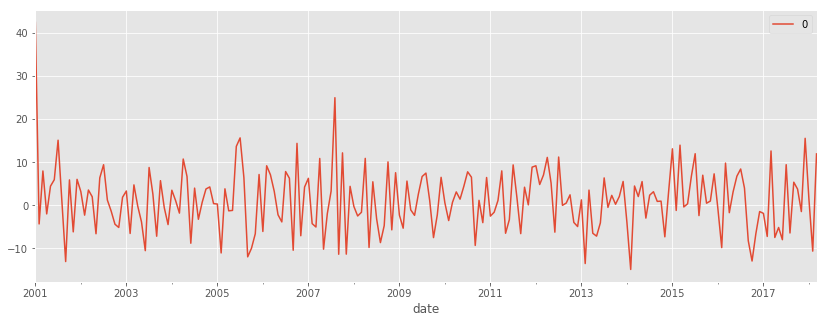

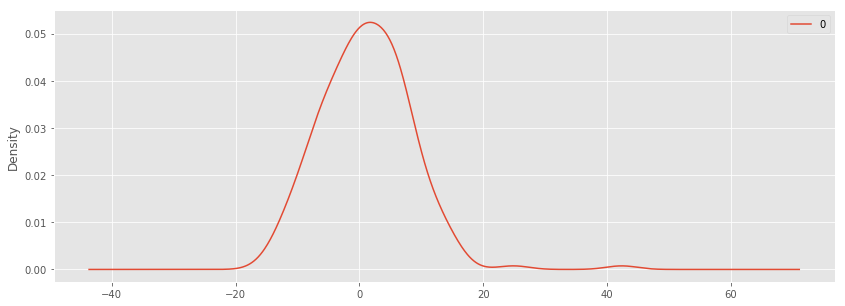

                0
count  207.000000
mean     1.086978
std      7.385014
min    -14.989805
25%     -4.056800
50%      0.977447
75%      5.893020
max     42.388663


In [130]:
# line plot of residuals
residuals = pd.DataFrame(model_train.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())


In [131]:
residuals.dropna(inplace=True)
dftest = adfuller(residuals)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',\
        'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -4.364970
p-value                          0.000342
#Lags Used                      12.000000
Number of Observations Used    194.000000
Critical Value (1%)             -3.464515
Critical Value (5%)             -2.876556
Critical Value (10%)            -2.574775
dtype: float64


In [137]:
y_hat_train = model_train.predict(typ='levels')
RMSE_train=np.sqrt(mean_squared_error(train, y_hat_train))
RMSE_train

7.446911150925585

> add color with colorama to this

### Best model on validation set

In [133]:
model_val = ARIMA(val, order=(8, 1, 2))
model_val.initialize_approximate_diffuse()
mod=model_val.fit()
#res_arma = mod_arma
print(mod.summary())

                               SARIMAX Results                                
Dep. Variable:       Generation (TWh)   No. Observations:                   14
Model:                 ARIMA(8, 1, 2)   Log Likelihood                 -55.051
Date:                Sun, 12 Mar 2023   AIC                            132.103
Time:                        22:27:55   BIC                            138.317
Sample:                    03-01-2018   HQIC                           130.826
                         - 04-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0750     16.995      0.004      0.996     -33.235      33.385
ar.L2          0.5502      3.721      0.148      0.882      -6.743       7.844
ar.L3         -0.1673     11.914     -0.014      0.9

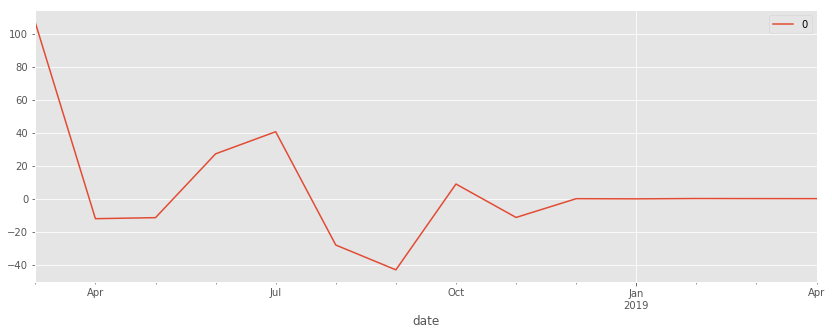

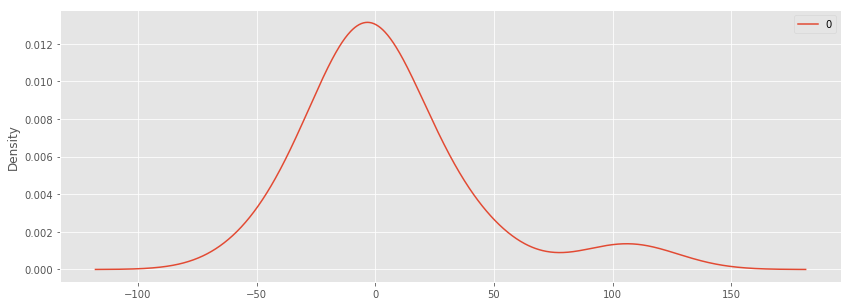

                0
count   14.000000
mean     5.468005
std     35.568968
min    -43.139547
25%    -11.497731
50%     -0.034076
75%      6.646682
max    106.523780


In [134]:
# line plot of residuals
residuals = pd.DataFrame(mod.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [135]:
residuals.dropna(inplace=True)
dftest = adfuller(residuals)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',\
        'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                -2.530350
p-value                        0.108263
#Lags Used                     5.000000
Number of Observations Used    8.000000
Critical Value (1%)           -4.665186
Critical Value (5%)           -3.367187
Critical Value (10%)          -2.802961
dtype: float64


In [147]:
y_hat_val = mod.predict(typ='levels')
RMSE_val=np.sqrt(mean_squared_error(val, y_hat_val))
RMSE_val

34.70853740345597

> add color with colorama to this

As we can see we are probably starting to overfit because the RMSE for the validation set is much higher than the one for th train set.
The residuals are also not really stationary but that can be also expected given the small size of the sample.

### Let's try another grid search for ARIMA

In [138]:
# evaluate parameters
p_values = [8, 10, 12, 20]
d_values = [1]
q_values = [2]
warnings.filterwarnings("ignore")
evaluate_models_aic(train.values, p_values, d_values, q_values)

ARIMA(8, 1, 2) AIC=1401.174
ARIMA(10, 1, 2) AIC=1382.235
ARIMA(12, 1, 2) AIC=1357.197
ARIMA(20, 1, 2) AIC=1361.479
Best ARIMA(12, 1, 2) AIC=1357.197


Taking the best model from this search

In [143]:
model_train = ARIMA(train, order=(12, 1, 2)).fit()
#res_arma = mod_arma
print(model_train.summary())

                               SARIMAX Results                                
Dep. Variable:       Generation (TWh)   No. Observations:                  207
Model:                ARIMA(12, 1, 2)   Log Likelihood                -663.599
Date:                Sun, 12 Mar 2023   AIC                           1357.197
Time:                        22:29:32   BIC                           1407.116
Sample:                    01-01-2001   HQIC                          1377.386
                         - 03-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0220      0.114     -0.193      0.847      -0.245       0.201
ar.L2         -0.1058      0.133     -0.796      0.426      -0.366       0.155
ar.L3         -0.1393      0.077     -1.813      0.0

In [144]:
residuals.dropna(inplace=True)
dftest = adfuller(residuals)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',\
        'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                -2.530350
p-value                        0.108263
#Lags Used                     5.000000
Number of Observations Used    8.000000
Critical Value (1%)           -4.665186
Critical Value (5%)           -3.367187
Critical Value (10%)          -2.802961
dtype: float64


In [145]:
y_hat_train = model_train.predict(typ='levels')
RMSE_train=np.sqrt(mean_squared_error(train, y_hat_train))
RMSE_train

6.73308105311345

Using it on the validation set

In [149]:
model_val = ARIMA(val, order=(12, 1, 2)).fit()
#res_arma = mod_arma
print(model_val.summary())

                               SARIMAX Results                                
Dep. Variable:       Generation (TWh)   No. Observations:                   14
Model:                ARIMA(12, 1, 2)   Log Likelihood                 -34.916
Date:                Sun, 12 Mar 2023   AIC                             99.831
Time:                        22:31:41   BIC                            108.305
Sample:                    03-01-2018   HQIC                            98.089
                         - 04-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0472    284.015      0.000      1.000    -556.613     556.707
ar.L2          0.4715     58.030      0.008      0.994    -113.265     114.208
ar.L3         -0.6327     25.654     -0.025      0.9

In [150]:
y_hat_val = model_val.predict(typ='levels')
RMSE_val=np.sqrt(mean_squared_error(val, y_hat_val))
RMSE_val

30.308012664116085

> add color with colorama to this

So, that is good but I have to start to keep in mind overfitting because that's what becomes an issue

# Including Seasonality: SARIMAX

Add a paragraph that explains why we need to do this and why it's powerful.

## Grid Search SARIMAX

In [153]:
# Define the p, d and q parameters to take any value between 0 and 2
p = [1, 2, 4,  6, 8]
d = [1, 2, 4]
q = range(1,3)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


In [154]:
"""
CODE that was used to conduct the SARIMAX grid search:

ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        except:
            continue"""

ARIMA (1, 1, 1) x (1, 1, 1, 12): AIC Calculated=1113.7964687552999
ARIMA (1, 1, 1) x (1, 1, 2, 12): AIC Calculated=1045.4449049384093
ARIMA (1, 1, 1) x (1, 2, 1, 12): AIC Calculated=1119.2037305736499
ARIMA (1, 1, 1) x (1, 2, 2, 12): AIC Calculated=1008.6660220482034
ARIMA (1, 1, 1) x (1, 4, 1, 12): AIC Calculated=1186.2337398632196
ARIMA (1, 1, 1) x (1, 4, 2, 12): AIC Calculated=1058.7665842684605
ARIMA (1, 1, 1) x (2, 1, 1, 12): AIC Calculated=1051.3992855627516
ARIMA (1, 1, 1) x (2, 1, 2, 12): AIC Calculated=1046.9614638240046
ARIMA (1, 1, 1) x (2, 2, 1, 12): AIC Calculated=1042.9265630944415
ARIMA (1, 1, 1) x (2, 2, 2, 12): AIC Calculated=1030.2643720188216
ARIMA (1, 1, 1) x (2, 4, 1, 12): AIC Calculated=1032.0225707138466
ARIMA (1, 1, 1) x (2, 4, 2, 12): AIC Calculated=1028.9972031536156
ARIMA (1, 1, 1) x (4, 1, 1, 12): AIC Calculated=902.0345758087595
ARIMA (1, 1, 1) x (4, 1, 2, 12): AIC Calculated=903.6290694128154
ARIMA (1, 1, 1) x (4, 2, 1, 12): AIC Calculated=874.219952721114

ARIMA (1, 4, 1) x (1, 4, 1, 12): AIC Calculated=1326.6446203657833
ARIMA (1, 4, 1) x (1, 4, 2, 12): AIC Calculated=1352.7522008364742
ARIMA (1, 4, 1) x (2, 1, 1, 12): AIC Calculated=1285.8219330517459
ARIMA (1, 4, 1) x (2, 1, 2, 12): AIC Calculated=1276.1230440195295
ARIMA (1, 4, 1) x (2, 2, 1, 12): AIC Calculated=1255.107101973827
ARIMA (1, 4, 1) x (2, 2, 2, 12): AIC Calculated=1216.5487457276197
ARIMA (1, 4, 1) x (2, 4, 1, 12): AIC Calculated=1248.503135724428
ARIMA (1, 4, 1) x (2, 4, 2, 12): AIC Calculated=1218.4237250579386
ARIMA (1, 4, 1) x (4, 1, 1, 12): AIC Calculated=1105.2616285268566
ARIMA (1, 4, 1) x (4, 1, 2, 12): AIC Calculated=1104.8863619944066
ARIMA (1, 4, 1) x (4, 2, 1, 12): AIC Calculated=1035.4198107559391
ARIMA (1, 4, 1) x (4, 2, 2, 12): AIC Calculated=1039.551840767413
ARIMA (1, 4, 1) x (4, 4, 1, 12): AIC Calculated=1088.1074671151923
ARIMA (1, 4, 1) x (4, 4, 2, 12): AIC Calculated=1204.9250149897896
ARIMA (1, 4, 1) x (6, 1, 1, 12): AIC Calculated=880.1273812338607

ARIMA (2, 2, 1) x (2, 2, 1, 12): AIC Calculated=1042.9498106465117
ARIMA (2, 2, 1) x (2, 2, 2, 12): AIC Calculated=1041.4735075709502
ARIMA (2, 2, 1) x (2, 4, 1, 12): AIC Calculated=1026.7260698791642
ARIMA (2, 2, 1) x (2, 4, 2, 12): AIC Calculated=1025.7331147870846
ARIMA (2, 2, 1) x (4, 1, 1, 12): AIC Calculated=900.0895999601573
ARIMA (2, 2, 1) x (4, 1, 2, 12): AIC Calculated=901.6429367872413
ARIMA (2, 2, 1) x (4, 2, 1, 12): AIC Calculated=871.1421601780361
ARIMA (2, 2, 1) x (4, 2, 2, 12): AIC Calculated=873.1417624100073
ARIMA (2, 2, 1) x (4, 4, 1, 12): AIC Calculated=829.6715691579547
ARIMA (2, 2, 1) x (4, 4, 2, 12): AIC Calculated=831.3523802750926
ARIMA (2, 2, 1) x (6, 1, 1, 12): AIC Calculated=732.758095283838
ARIMA (2, 2, 1) x (6, 1, 2, 12): AIC Calculated=734.4128926902741
ARIMA (2, 2, 1) x (6, 2, 1, 12): AIC Calculated=683.2030835109083
ARIMA (2, 2, 1) x (6, 2, 2, 12): AIC Calculated=682.4322183147856
ARIMA (2, 2, 1) x (6, 4, 1, 12): AIC Calculated=631.7233648654325
ARIMA (

ARIMA (4, 1, 1) x (4, 1, 1, 12): AIC Calculated=889.3174695504702
ARIMA (4, 1, 1) x (4, 1, 2, 12): AIC Calculated=890.5937237091638
ARIMA (4, 1, 1) x (4, 2, 1, 12): AIC Calculated=859.4440508007854
ARIMA (4, 1, 1) x (4, 2, 2, 12): AIC Calculated=859.8956158420033
ARIMA (4, 1, 1) x (4, 4, 1, 12): AIC Calculated=826.8106393685096
ARIMA (4, 1, 1) x (4, 4, 2, 12): AIC Calculated=819.1525903704278
ARIMA (4, 1, 1) x (6, 1, 1, 12): AIC Calculated=724.7666751985039
ARIMA (4, 1, 1) x (6, 1, 2, 12): AIC Calculated=726.7594943757783
ARIMA (4, 1, 1) x (6, 2, 1, 12): AIC Calculated=669.3489224147852
ARIMA (4, 1, 1) x (6, 2, 2, 12): AIC Calculated=672.714367844016
ARIMA (4, 1, 1) x (6, 4, 1, 12): AIC Calculated=613.697259873972
ARIMA (4, 1, 1) x (6, 4, 2, 12): AIC Calculated=621.1144148995048
ARIMA (4, 1, 1) x (8, 1, 1, 12): AIC Calculated=585.9874435382173
ARIMA (4, 1, 1) x (8, 1, 2, 12): AIC Calculated=588.5830007774622
ARIMA (4, 1, 1) x (8, 2, 1, 12): AIC Calculated=533.7834931666287
ARIMA (4, 1,

ARIMA (4, 4, 1) x (4, 4, 1, 12): AIC Calculated=1325.763965571438
ARIMA (4, 4, 1) x (4, 4, 2, 12): AIC Calculated=1306.1294300111947
ARIMA (4, 4, 1) x (6, 1, 1, 12): AIC Calculated=785.3998984177528
ARIMA (4, 4, 1) x (6, 1, 2, 12): AIC Calculated=786.3653835002142
ARIMA (4, 4, 1) x (6, 2, 1, 12): AIC Calculated=725.8363649289561
ARIMA (4, 4, 1) x (6, 2, 2, 12): AIC Calculated=727.3710890474694
ARIMA (4, 4, 1) x (6, 4, 1, 12): AIC Calculated=997.7028458548052
ARIMA (4, 4, 1) x (6, 4, 2, 12): AIC Calculated=960.3192497159974
ARIMA (4, 4, 1) x (8, 1, 1, 12): AIC Calculated=632.6743885207148
ARIMA (4, 4, 1) x (8, 1, 2, 12): AIC Calculated=623.4102715984535
ARIMA (4, 4, 1) x (8, 2, 1, 12): AIC Calculated=564.2744167899639
ARIMA (4, 4, 1) x (8, 2, 2, 12): AIC Calculated=561.852955651865
ARIMA (4, 4, 1) x (8, 4, 1, 12): AIC Calculated=509.67074923716274
ARIMA (4, 4, 1) x (8, 4, 2, 12): AIC Calculated=539.8524049359753
ARIMA (4, 4, 2) x (1, 1, 1, 12): AIC Calculated=1184.7031154111014
ARIMA (4

ARIMA (6, 2, 1) x (6, 2, 1, 12): AIC Calculated=663.3216859228779
ARIMA (6, 2, 1) x (6, 2, 2, 12): AIC Calculated=664.7672588296414
ARIMA (6, 2, 1) x (6, 4, 1, 12): AIC Calculated=626.1090180162953
ARIMA (6, 2, 1) x (6, 4, 2, 12): AIC Calculated=606.3858490976943
ARIMA (6, 2, 1) x (8, 1, 1, 12): AIC Calculated=577.7797383769094
ARIMA (6, 2, 1) x (8, 1, 2, 12): AIC Calculated=572.6956794533305
ARIMA (6, 2, 1) x (8, 2, 1, 12): AIC Calculated=519.5705732830088
ARIMA (6, 2, 1) x (8, 2, 2, 12): AIC Calculated=519.5358828351015
ARIMA (6, 2, 1) x (8, 4, 1, 12): AIC Calculated=424.19299444660686
ARIMA (6, 2, 1) x (8, 4, 2, 12): AIC Calculated=463.29785414592516
ARIMA (6, 2, 2) x (1, 1, 1, 12): AIC Calculated=1110.209802740443
ARIMA (6, 2, 2) x (1, 1, 2, 12): AIC Calculated=1058.4165427599082
ARIMA (6, 2, 2) x (1, 2, 1, 12): AIC Calculated=1101.7568476305187
ARIMA (6, 2, 2) x (1, 2, 2, 12): AIC Calculated=1019.9641863959994
ARIMA (6, 2, 2) x (1, 4, 1, 12): AIC Calculated=1142.1580695162847
ARIM

ARIMA (8, 1, 1) x (8, 1, 1, 12): AIC Calculated=556.5266105137711
ARIMA (8, 1, 1) x (8, 1, 2, 12): AIC Calculated=558.5234507417883
ARIMA (8, 1, 1) x (8, 2, 1, 12): AIC Calculated=508.02085214639226
ARIMA (8, 1, 1) x (8, 2, 2, 12): AIC Calculated=508.03688747399383
ARIMA (8, 1, 1) x (8, 4, 1, 12): AIC Calculated=442.0055892318715
ARIMA (8, 1, 1) x (8, 4, 2, 12): AIC Calculated=404.02012265374526
ARIMA (8, 1, 2) x (1, 1, 1, 12): AIC Calculated=1088.5460357591437
ARIMA (8, 1, 2) x (1, 1, 2, 12): AIC Calculated=1048.4418195846843
ARIMA (8, 1, 2) x (1, 2, 1, 12): AIC Calculated=1080.0791169410754
ARIMA (8, 1, 2) x (1, 2, 2, 12): AIC Calculated=1013.9014662053016
ARIMA (8, 1, 2) x (1, 4, 1, 12): AIC Calculated=1107.6978650106544
ARIMA (8, 1, 2) x (1, 4, 2, 12): AIC Calculated=1037.4493769549415
ARIMA (8, 1, 2) x (2, 1, 1, 12): AIC Calculated=1016.9315609801121
ARIMA (8, 1, 2) x (2, 1, 2, 12): AIC Calculated=1014.1418545596489
ARIMA (8, 1, 2) x (2, 2, 1, 12): AIC Calculated=985.5930670285688

ARIMA (8, 4, 1) x (8, 4, 1, 12): AIC Calculated=649.82935005168
ARIMA (8, 4, 1) x (8, 4, 2, 12): AIC Calculated=606.3134252837258
ARIMA (8, 4, 2) x (1, 1, 1, 12): AIC Calculated=1164.5845036184578
ARIMA (8, 4, 2) x (1, 1, 2, 12): AIC Calculated=1116.9139027008118
ARIMA (8, 4, 2) x (1, 2, 1, 12): AIC Calculated=1154.7094587042418
ARIMA (8, 4, 2) x (1, 2, 2, 12): AIC Calculated=1094.743766188669
ARIMA (8, 4, 2) x (1, 4, 1, 12): AIC Calculated=1641.2292347798775
ARIMA (8, 4, 2) x (1, 4, 2, 12): AIC Calculated=1555.6005204093387
ARIMA (8, 4, 2) x (2, 1, 1, 12): AIC Calculated=1092.6684202718081
ARIMA (8, 4, 2) x (2, 1, 2, 12): AIC Calculated=1089.1668226750867
ARIMA (8, 4, 2) x (2, 2, 1, 12): AIC Calculated=1054.643886052968
ARIMA (8, 4, 2) x (2, 2, 2, 12): AIC Calculated=1057.9470813590724
ARIMA (8, 4, 2) x (2, 4, 1, 12): AIC Calculated=1452.2335811089188
ARIMA (8, 4, 2) x (2, 4, 2, 12): AIC Calculated=1380.4908150510807
ARIMA (8, 4, 2) x (4, 1, 1, 12): AIC Calculated=911.171301217279
ARI

In [155]:
""" CODE used to extract the model with lowest AIC

# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]"""

pdq         (8, 2, 2)
pdqs    (8, 4, 1, 12)
aic           390.301
Name: 838, dtype: object

The output of our code suggests that ARIMA (1, 1, 1) x (1, 1, 1, 12) yields the lowest AIC value of 277.78. We should therefore consider this to be optimal option out of all the models we have considered.

It is very time consuming to run all of the options so we pickled the GridSearchCV models after we ran them and fit them.
The pickled files were also too large for the Github Repository so we had to remove them.
We show below all the code that was used for demonastrative purposes, but we comment it out and keep only the results of the search.


In [187]:
# CODE used to pickle df of results
# ans_df.to_pickle("./SARgrid1.pkl")

In [182]:
res_grid_df = pd.read_pickle("./SARgrid1.pkl")  
res_grid_df 

,pdq,pdqs,aic
0,"(1, 1, 1)","(1, 1, 1, 12)",1113.796469
1,"(1, 1, 1)","(1, 1, 2, 12)",1045.444905
2,"(1, 1, 1)","(1, 2, 1, 12)",1119.203731
3,"(1, 1, 1)","(1, 2, 2, 12)",1008.666022
4,"(1, 1, 1)","(1, 4, 1, 12)",1186.233740
...,...,...,...
895,"(8, 4, 2)","(8, 1, 2, 12)",598.278003
896,"(8, 4, 2)","(8, 2, 1, 12)",581.777049
897,"(8, 4, 2)","(8, 2, 2, 12)",566.100169
898,"(8, 4, 2)","(8, 4, 1, 12)",643.207771


In [186]:
res_grid_df.sort_values(by='aic').head(10)

,pdq,pdqs,aic
838,"(8, 2, 2)","(8, 4, 1, 12)",390.300560
568,"(6, 1, 1)","(8, 4, 1, 12)",401.144101
749,"(8, 1, 1)","(8, 4, 2, 12)",404.020123
598,"(6, 1, 2)","(8, 4, 1, 12)",406.228081
779,"(8, 1, 2)","(8, 4, 2, 12)",407.293806
388,"(4, 1, 1)","(8, 4, 1, 12)",412.478274
569,"(6, 1, 1)","(8, 4, 2, 12)",412.843780
599,"(6, 1, 2)","(8, 4, 2, 12)",415.171388
839,"(8, 2, 2)","(8, 4, 2, 12)",416.268315
628,"(6, 2, 1)","(8, 4, 1, 12)",424.192994


Fitting an ARIMA Time Series Model
Using grid search, we have identified the set of parameters that produces the best fitting model to our time series data. We can proceed to analyze this particular model in more depth.

We'll start by plugging the optimal parameter values into a new SARIMAX model.

# Now change to the actual three best in the next section and the following one with forecaasting

### 3 Best SARIMAX models according to first (super long) grid search

In [151]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL1 = sm.tsa.statespace.SARIMAX(train, 
                                        order=(1, 2, 2), 
                                        seasonal_order=(2, 1, 4, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output1 = ARIMA_MODEL1.fit()

print(output1.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1620      0.283      0.573      0.567      -0.393       0.717
ma.L1         -1.4746     32.063     -0.046      0.963     -64.316      61.367
ma.L2          0.4745     15.282      0.031      0.975     -29.479      30.428
ar.S.L12       0.2369      0.399      0.594      0.553      -0.545       1.019
ar.S.L24       0.0054      0.382      0.014      0.989      -0.744       0.755
ma.S.L12      34.8258    912.061      0.038      0.970   -1752.781    1822.432
ma.S.L24     -41.4174   1034.904     -0.040      0.968   -2069.792    1986.957
ma.S.L36       4.5779     95.083      0.048      0.962    -181.782     190.938
ma.S.L48       7.5515    194.431      0.039      0.969    -373.526     388.629
sigma2         0.0201      1.147      0.018      0.986      -2.227       2.268


The model returns a lot of information, but we'll focus only on the table of coefficients. The coef column above shows the importance of each feature and how each one impacts the time series patterns. The  𝑃>|𝑧|
  provides the significance of each feature weight.

For our time-series, we see that each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

In [152]:
y_hat_train1 = output1.predict(typ='levels')
RMSE_train1=np.sqrt(mean_squared_error(train, y_hat_train1))
RMSE_train1

8.933938974383704

Next, we shall run model diagnostics to ensure that none of the assumptions made by the model have been violated.

Call the .plot_diagnostics( ) method on ARIMA output below:

In [ ]:
# Call plot_diagnostics() on the results calculated above 
output1.plot_diagnostics(figsize=(15, 18))
plt.show()

The purpose here is to ensure that residuals remain uncorrelated, normally distributed having zero mean. In the absence of these assumptions, we can not move forward and need further tweaking of the model.

Let's check for these assumptions from diagnostics plots.

In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.

The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

These observations lead us to conclude that our model has no correlations and provides a satisfactory fit to help forecast future values.

In [ ]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL2 = sm.tsa.statespace.SARIMAX(train, 
                                        order=(1, 2, 3), 
                                        seasonal_order=(2, 1, 4, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output2 = ARIMA_MODEL2.fit()

print(output2.summary().tables[1])

In [ ]:
y_hat_train2 = output2.predict(typ='levels')
RMSE_train2=np.sqrt(mean_squared_error(train, y_hat_train2))
RMSE_train2

In [ ]:
# Call plot_diagnostics() on the results calculated above 
output2.plot_diagnostics(figsize=(15, 18))
plt.show()

In [ ]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL3 = sm.tsa.statespace.SARIMAX(train, 
                                        order=(1, 2, 4), 
                                        seasonal_order=(1, 2, 4, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output3 = ARIMA_MODEL3.fit()

print(output3.summary().tables[1])

In [ ]:
y_hat_train3 = output3.predict(typ='levels')
RMSE_train3 = np.sqrt(mean_squared_error(train, y_hat_train3))
RMSE_train3

In [ ]:
# Call plot_diagnostics() on the results calculated above 
output3.plot_diagnostics(figsize=(15, 18))
plt.show()

## Validating the model

Do both one-step-ahead and dynamic forecasting, maybe with top 3 performing models.
Calculating RMSE on the train and the validation set, to choose the best model.

### One step Ahead Forecasting

In [ ]:
pred1 = output1.get_prediction(start=pd.to_datetime('2018-03-01'), end=pd.to_datetime('2018-03-01'), dynamic=False)
pred_conf = pred1.conf_int()

In [ ]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = nat.plot(label='observed')

# Plot predicted values
pred1.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Generation (TWh)')
plt.legend()

plt.show()

In [ ]:
# Get the real and predicted values
nat_forecasted = pred1.predicted_mean
nat_truth = test

# Compute the mean square error
mse = ((nat_forecasted - nat_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


#### Second Model

In [ ]:
pred2 = output2.get_prediction(start=pd.to_datetime('2018-03-01'), dynamic=False)
pred_conf = pred2.conf_int()

In [ ]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = nat.plot(label='observed')

# Plot predicted values
pred2.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Generation (TWh)')
plt.legend()

plt.show()

In [ ]:
# Get the real and predicted values
nat_forecasted = pred2.predicted_mean
nat_truth = test

# Compute the mean square error
mse = ((nat_forecasted - nat_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

#### Third model

In [ ]:
pred3 = output3.get_prediction(start=pd.to_datetime('2018-03-01'), dynamic=False)
pred_conf = pred3.conf_int()

In [ ]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = nat.plot(label='observed')

# Plot predicted values
pred3.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Generation (TWh)')
plt.legend()

plt.show()

In [ ]:
# Get the real and predicted values
nat_forecasted = pred3.predicted_mean
nat_truth = test

# Compute the mean square error
mse = ((nat_forecasted - nat_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

Third model wins. Nice.

### Dynamic Forecasting

In [ ]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic1 = output1.get_prediction(pd.to_datetime('2018-03-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic1.conf_int()

In [ ]:
# Plot the dynamic forecast with confidence intervals.

ax = nat.plot(label='observed', figsize=(20, 15))
pred_dynamic1.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2018-03-01'), nat_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Generation (TWh)')

plt.legend()
plt.show()

In [ ]:
# Get the real and predicted values
nat_forecasted = pred_dynamic1.predicted_mean
nat_truth = test

# Compute the mean square error
mse = ((nat_forecasted - nat_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

Second SARIMAX

In [ ]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic2 = output2.get_prediction(pd.to_datetime('2018-03-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic2.conf_int()

In [ ]:
# Plot the dynamic forecast with confidence intervals.

ax = nat.plot(label='observed', figsize=(20, 15))
pred_dynamic2.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2018-03-01'), nat_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Generation (TWh)')

plt.legend()
plt.show()

In [ ]:
# Get the real and predicted values
nat_forecasted = pred_dynamic2.predicted_mean
nat_truth = test

# Compute the mean square error
mse = ((nat_forecasted - nat_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

SARIMAX 3

In [ ]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic3 = output3.get_prediction(pd.to_datetime('2018-03-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic3.conf_int()

In [ ]:
# Plot the dynamic forecast with confidence intervals.

ax = nat.plot(label='observed', figsize=(20, 15))
pred_dynamic3.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2018-03-01'), nat_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Generation (TWh)')

plt.legend()
plt.show()

In [ ]:
# Get the real and predicted values
nat_forecasted = pred_dynamic3.predicted_mean
nat_truth = test

# Compute the mean square error
mse = ((nat_forecasted - nat_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

Or figure out what Greg was doing with the validation set.

in any case learning how to do
## Forecasting

### Third Grid Search SARIMAX

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = [1, 4, 8]
d = range(1,3)
q = [4]
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
"""ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        except:
            continue"""

In [ ]:
"""# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]"""

In [ ]:
"""ans_df.to_pickle("./resgrid.pkl")"""

In [ ]:
unpickled_df2 = pd.read_pickle("./resgrid.pkl")  
unpickled_df2

In [ ]:
#Define the p, d and q parameters to take any value between 0 and 2
p = [1, 2, 4, 6, 8]
d = range(1,3)
q = range(1,3)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
"""ans2 = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        except:
            continue"""

In [ ]:
"""# Find the parameters with minimal AIC value
ans2_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans2_df.loc[ans2_df['aic'].idxmin()]"""

ans2_df

In [ ]:
unpickled2_df = pd.read_pickle("./resgrid2.pkl")  
unpickled2_df

In [ ]:
unpickled2_df.isna().sum()

In [ ]:
unpickled2_df.loc[unpickled2_df['aic'].idxmin()]